# <font color="#1b5776">1. <u>Adding Imports</u></font>

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression,Lasso
from xgboost import XGBClassifier,XGBRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import mean_squared_error
import pickle

from prettytable import PrettyTable
from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

# <font color="#1b5776">2. <u>Getting the Data</u></font>

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/train_new_visitor_level.csv",dtype={"fullVisitorId":"str"})

test = pd.read_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/test_new_visitor_level.csv",dtype={"fullVisitorId":"str"})

In [ ]:
print("train shape:",train.shape)
print("test shape:",test.shape)

train shape: (1417575, 119)
test shape: (296530, 118)


In [ ]:
train.head(2)

,fullVisitorId,channelGrouping_ModeMax,date_Span,visitNumber_ModeMax,visitNumber_Median,visitNumber_Mean,visitNumber_Sum,visitNumber_Min,visitNumber_Max,device_browser_ModeMax,device_operatingSystem_ModeMax,device_isMobile_ModeMax,device_deviceCategory_ModeMax,geoNetwork_continent_ModeMax,geoNetwork_subContinent_ModeMax,geoNetwork_country_ModeMax,geoNetwork_region_ModeMax,geoNetwork_metro_ModeMax,geoNetwork_city_ModeMax,geoNetwork_networkDomain_ModeMax,totals_hits_Median,totals_hits_Mean,totals_hits_Sum,totals_hits_Min,totals_hits_Max,totals_pageviews_Median,totals_pageviews_Mean,totals_pageviews_Sum,totals_pageviews_Min,totals_pageviews_Max,totals_sessionQualityDim_Median,totals_sessionQualityDim_Mean,totals_sessionQualityDim_Sum,totals_sessionQualityDim_Min,totals_sessionQualityDim_Max,totals_timeOnSite_Median,totals_timeOnSite_Mean,totals_timeOnSite_Sum,totals_timeOnSite_Min,totals_timeOnSite_Max,...,weekOfYear_Mean,weekOfYear_Sum,weekOfYear_Min,weekOfYear_Max,dayOfYear_ModeMax,dayOfYear_Median,dayOfYear_Mean,dayOfYear_Sum,dayOfYear_Min,dayOfYear_Max,quarter_ModeMax,quarter_Median,quarter_Mean,quarter_Sum,quarter_Min,quarter_Max,isYearEnd_ModeMax,is_weekend_ModeMax,visit_hr_ModeMax,visit_hr_Median,visit_hr_Mean,visit_hr_Sum,visit_hr_Min,visit_hr_Max,visit_min_Median,visit_min_Mean,visit_min_Sum,visit_min_Min,visit_min_Max,visit_sec_Median,visit_sec_Mean,visit_sec_Sum,visit_sec_Min,visit_sec_Max,time_of_day_ModeMax,is_office_hours_ModeMax,returnedPostGap,totals_transactionRevenue_LogOfSum,firstVisit_AfterStart,lastVisit_BeforeEnd
0,0000010278554503158,7,0,1,1.0,1.0,1.0,1,1,21,13,1,2,3,0,15,94,26,119,406,3.0,3.0,3.0,3,3,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,61.0,61.0,61.0,61.0,61.0,...,42.0,42.0,42,42,294,294.0,294.0,294.0,294,294,4,4.0,4.0,4.0,4,4,0,1,5,5.0,5.0,5.0,5,5,57.0,57.0,57.0,57,57,46.0,46.0,46.0,46,46,1,1,0,0.0,80,87
1,0000020424342248747,7,0,1,1.0,1.0,1.0,1,1,20,10,0,1,4,17,47,61,26,74,1349,4.0,4.0,4.0,4,4,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,51.0,51.0,51.0,51.0,51.0,...,48.0,48.0,48,48,335,335.0,335.0,335.0,335,335,4,4.0,4.0,4.0,4,4,0,1,7,7.0,7.0,7.0,7,7,55.0,55.0,55.0,55,55,1.0,1.0,1.0,1,1,0,1,0,0.0,121,46


In [ ]:
test.head(2)

,fullVisitorId,channelGrouping_ModeMax,date_Span,visitNumber_ModeMax,visitNumber_Median,visitNumber_Mean,visitNumber_Sum,visitNumber_Min,visitNumber_Max,device_browser_ModeMax,device_operatingSystem_ModeMax,device_isMobile_ModeMax,device_deviceCategory_ModeMax,geoNetwork_continent_ModeMax,geoNetwork_subContinent_ModeMax,geoNetwork_country_ModeMax,geoNetwork_region_ModeMax,geoNetwork_metro_ModeMax,geoNetwork_city_ModeMax,geoNetwork_networkDomain_ModeMax,totals_hits_Median,totals_hits_Mean,totals_hits_Sum,totals_hits_Min,totals_hits_Max,totals_pageviews_Median,totals_pageviews_Mean,totals_pageviews_Sum,totals_pageviews_Min,totals_pageviews_Max,totals_sessionQualityDim_Median,totals_sessionQualityDim_Mean,totals_sessionQualityDim_Sum,totals_sessionQualityDim_Min,totals_sessionQualityDim_Max,totals_timeOnSite_Median,totals_timeOnSite_Mean,totals_timeOnSite_Sum,totals_timeOnSite_Min,totals_timeOnSite_Max,...,weekOfYear_Median,weekOfYear_Mean,weekOfYear_Sum,weekOfYear_Min,weekOfYear_Max,dayOfYear_ModeMax,dayOfYear_Median,dayOfYear_Mean,dayOfYear_Sum,dayOfYear_Min,dayOfYear_Max,quarter_ModeMax,quarter_Median,quarter_Mean,quarter_Sum,quarter_Min,quarter_Max,isYearEnd_ModeMax,is_weekend_ModeMax,visit_hr_ModeMax,visit_hr_Median,visit_hr_Mean,visit_hr_Sum,visit_hr_Min,visit_hr_Max,visit_min_Median,visit_min_Mean,visit_min_Sum,visit_min_Min,visit_min_Max,visit_sec_Median,visit_sec_Mean,visit_sec_Sum,visit_sec_Min,visit_sec_Max,time_of_day_ModeMax,is_office_hours_ModeMax,totals_transactionRevenue_LogOfSum,firstVisit_AfterStart,lastVisit_BeforeEnd
0,0000018966949534117,7,0,1,1.0,1.0,1.0,1,1,21,8,0,1,4,3,109,94,26,119,1349,1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1,0.0,0.0,0.0,0.0,0.0,...,33.0,33.0,33.0,33,33,225,225.0,225.0,225.0,225,225,3,3.0,3.0,3.0,3,3,1,1,3,3.0,3.0,3.0,3,3,17.0,17.0,17.0,17,17,14.0,14.0,14.0,14,14,1,1,0.0,104,63
1,0000039738481224681,5,0,1,1.0,1.0,1.0,1,1,21,8,0,1,5,18,130,93,25,118,1349,1.0,1.0,1.0,1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1,0.0,0.0,0.0,0.0,0.0,...,24.0,24.0,24.0,24,24,164,164.0,164.0,164.0,164,164,2,2.0,2.0,2.0,2,2,1,1,1,1.0,1.0,1.0,1,1,16.0,16.0,16.0,16,16,14.0,14.0,14.0,14,14,1,1,0.0,43,124


# <font color="#1b5776">3. <u>Data Preparation for Modelling</u></font>

In [ ]:
# Columns not to be fed into the model:-
# fullVisitorId & target columns in the 2 dataframes:-
train_columnsToDrop = ["fullVisitorId","returnedPostGap","totals_transactionRevenue_LogOfSum"]
test_columnsToDrop = ["fullVisitorId","totals_transactionRevenue_LogOfSum"]

In [ ]:
train['returnedPostGap'].value_counts()

0    1408858
1       8717
Name: returnedPostGap, dtype: int64

<font color="#8fce00"><h4><u><b>Note:</b></u></h4></font> 
Only 8717 customers in the 4 timeframes returned after 46 days.

## <font color="#8fce00"><u><b>Segregating data into 4 parts:-</b></u></font>
* X for classification model
* Y for classification model
* X for regression model
* Y for regression model

In [ ]:
trainX_cls = train.drop(columns=train_columnsToDrop,axis=1)
trainY_cls = train["returnedPostGap"]

trainX_reg = train[ train["returnedPostGap"]==1 ].drop(columns=train_columnsToDrop,axis=1)
trainY_reg = train["totals_transactionRevenue_LogOfSum"][ train["returnedPostGap"]==1 ]

testX = test.drop(columns=test_columnsToDrop,axis=1)
testY_reg = test["totals_transactionRevenue_LogOfSum"]

<font color="#8fce00"><h4><u><b>Note:</b></u></h4></font> 
* We need to first predict the testY (of classification), i.e. whether the visitor will return in the future time period of Dec 1st,2018 to Jan 31st,2019 or not.
* And then predict the revenue for the 296530 visitors in test dataset for future.

## <font color="#8fce00"><u><b>Time-Based Cross-Validation Split:-</b></u></font>
* The data we have is time-series data.
* So, it is of absolute importance that the data be split in time-based format.
* Help taken from:-
  * https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
  * https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split
* Performing 5-FOLD CV here.

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)  # defining the time-series split

# time-series cross-validation iterator for classification.
cv_iterator_cls = []
for train_indices,test_indices in tscv.split(X=trainX_cls, y=trainY_cls):
  cv_iterator_cls.append( (train_indices,test_indices) )

# time-series cross-validation iterator for regression.
cv_iterator_reg = []
for train_indices,test_indices in tscv.split(X=trainX_reg, y=trainY_reg):
  cv_iterator_reg.append( (train_indices,test_indices) )

# <font color="#1b5776">4. <u>Models</u></font>

<font color='#8fce00'>Note:</font>
* I'll be using log-loss and rmse as scoring for the Cross-Validation process.
* Log-loss for the classification process: since the data is highly imbalanced (and we cannot balance it in any way since the entire essence of detecting those "few customers" who will come back will go in vain if we do) and also so that the model captures the essence behind "probability of a customer returning after the gap period".
* And RMSE for the regression process for reasons mentioned in the EDA file.
* I've used "neg_log_loss" & "neg_root_mean_squared_error" so that the validation captures "HIGHER THE BETTER"
* Inspiration: [Metrics documentation in sklearn](https://scikit-learn.org/stable/modules/model_evaluation.html#:~:text=For%20the%20most%20common%20use%20cases%2C%20you%20can%20designate%20a%20scorer%20object%20with%20the%20scoring%20parameter%3B%20the%20table%20below%20shows%20all%20possible%20values.%20All%20scorer%20objects%20follow%20the%20convention%20that%20higher%20return%20values%20are%20better%20than%20lower%20return%20values)
* I'll not be computing any RMSE between the predicted and actual values of the test set because the actual revenue values of the test set we currently have is of the timeline 1st May,2018 to 15th Oct,2018. We'll be predicting for the future time period of 1st Dec,2018 to 31st Jan,2019 and report the models using the Kaggle Private Score only.

## <font color='#8fce00'>Defining Reusable Functions</font>

In [ ]:
def get_CrossValidators(validator_type,model_type,estimator_val,params,n_it=10):
  """Takes parameters for returning either GridSearchCV/RandomizedSearchCV cross-validators"""

  # SETTING CONDITIONS FOR CROSS-VALIDATION ITERATORS & SCORING.
  if model_type=="cls":
    cv_val=cv_iterator_cls
    scoring_val="neg_log_loss"
  elif model_type=="reg":
    cv_val=cv_iterator_reg
    scoring_val="neg_root_mean_squared_error"

  # SETTING CONDITIONS FOR DECIDING THE TYPE OF CROSS-VALIDATOR.
  if validator_type=="G":
    return GridSearchCV(estimator=estimator_val,param_grid=params,scoring=scoring_val,cv=cv_val,return_train_score=True)
  else:
    return RandomizedSearchCV(estimator=estimator_val,param_distributions=params,scoring=scoring_val,cv=cv_val,return_train_score=True,n_iter=n_it)

In [ ]:
def get_BestScoreParams(tuned_cls,tuned_reg):
  """Takes hyper-parameter tuned models and returns the best scores and parameters obtained after tuning via cross-validation"""
  
  print("For classifier:-")
  cls_best_params = tuned_cls.best_params_
  print("Best params-->",cls_best_params)
  print("Best score-->",tuned_cls.best_score_)
  print()
  print("For regressor:-")
  reg_best_params = tuned_reg.best_params_
  print("Best params-->",reg_best_params)
  print("Best score-->",tuned_reg.best_score_)
  return cls_best_params,reg_best_params

In [ ]:
def replace_negative_with_zero(x):
  """Returns 0 if x is negative else returns the same x"""
  if x<0:
    return 0
  else:
    return x

## 4.1. <font color='#8fce00'>Logistic Regression + Lasso Regression</font>

GridSearchCV Hyper-parameter tuning:-
* cls - penalty, C
* reg - alpha

### <font color='#088da5'>Defining: Classification & Regression Models for GridSearchCV</font>

In [ ]:
cls_logreg = LogisticRegression()
params_cls = {"penalty":["l1","l2"],"C":[10**i for i in range(-5,6)]}

reg_lasso = Lasso()
params_reg = {"alpha":[10**i for i in range(-5,6)]}

In [ ]:
cls_grid = get_CrossValidators(validator_type="G",model_type="cls",estimator_val=cls_logreg,params=params_cls)
reg_grid = get_CrossValidators(validator_type="G",model_type="reg",estimator_val=reg_lasso,params=params_reg)

### <font color='#088da5'>Fitting the GridSearchCV</font>

In [ ]:
%%time
cls_grid.fit(trainX_cls,trainY_cls)

CPU times: user 1h 7min 9s, sys: 25min 1s, total: 1h 32min 10s
Wall time: 24min 33s


GridSearchCV(cv=[(array([     0,      1,      2, ..., 236262, 236263, 236264]),
                  array([236265, 236266, 236267, ..., 472524, 472525, 472526])),
                 (array([     0,      1,      2, ..., 472524, 472525, 472526]),
                  array([472527, 472528, 472529, ..., 708786, 708787, 708788])),
                 (array([     0,      1,      2, ..., 708786, 708787, 708788]),
                  array([708789, 708790, 708791, ..., 945048, 945049, 945050])),
                 (array([     0,      1,      2, ..., 945048, 945049, 945050]),
                  array([ 945051,  945052,  945053, ..., 1181310, 1181311, 1181312])),
                 (array([      0,       1,       2, ..., 1181310, 1181311, 1181312]),
                  array([1181313, 1181314, 1181315, ..., 1417572, 1417573, 1417574]))],
             estimator=LogisticRegression(),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000, 100000],
  

In [ ]:
%%time
reg_grid.fit(trainX_reg,trainY_reg)

CPU times: user 18.9 s, sys: 21.6 s, total: 40.5 s
Wall time: 14.7 s


GridSearchCV(cv=[(array([   0,    1,    2, ..., 1454, 1455, 1456]),
                  array([1457, 1458, 1459, ..., 2906, 2907, 2908])),
                 (array([   0,    1,    2, ..., 2906, 2907, 2908]),
                  array([2909, 2910, 2911, ..., 4358, 4359, 4360])),
                 (array([   0,    1,    2, ..., 4358, 4359, 4360]),
                  array([4361, 4362, 4363, ..., 5810, 5811, 5812])),
                 (array([   0,    1,    2, ..., 5810, 5811, 5812]),
                  array([5813, 5814, 5815, ..., 7262, 7263, 7264])),
                 (array([   0,    1,    2, ..., 7262, 7263, 7264]),
                  array([7265, 7266, 7267, ..., 8714, 8715, 8716]))],
             estimator=Lasso(),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                   1000, 10000, 100000]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

### <font color='#088da5'>Best Parameters obtained via GridSearchCV</font>

In [ ]:
cls_best,reg_best = get_BestScoreParams(cls_grid,reg_grid)

For classifier:-
Best params--> {'C': 0.0001, 'penalty': 'l2'}
Best score--> -0.032681183079130025

For regressor:-
Best params--> {'alpha': 10}
Best score--> -2.429918264540567


### <font color='#088da5'>Training the Classification & Regression models using the Best Parameters obtained</font>

In [ ]:
cls_model = LogisticRegression(penalty=cls_best["penalty"], C=cls_best["C"])

reg_model = Lasso(alpha=reg_best["alpha"])

In [ ]:
%%time
cls_model.fit(trainX_cls,trainY_cls)

CPU times: user 2min 25s, sys: 42.6 s, total: 3min 8s
Wall time: 50.9 s


LogisticRegression(C=0.0001)

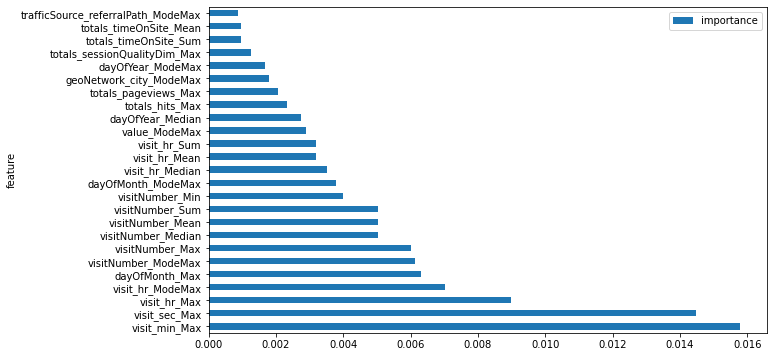

In [ ]:
cls_imp = pd.DataFrame({"feature":cls_model.feature_names_in_,
                        "importance":[val[0] for val in cls_model.coef_.reshape(-1,1)]}).sort_values(by="importance",ascending=False)[:25]

cls_imp.plot(kind="barh", x="feature", y="importance", figsize=(10,6))

In [ ]:
%%time
reg_model.fit(trainX_reg,trainY_reg)

CPU times: user 124 ms, sys: 210 ms, total: 333 ms
Wall time: 93.8 ms


Lasso(alpha=10)

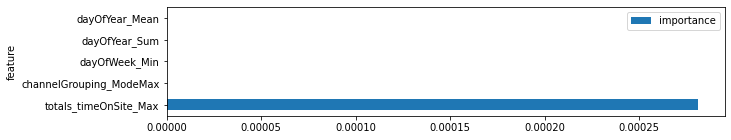

In [ ]:
reg_imp = pd.DataFrame({"feature":reg_model.feature_names_in_,
                        "importance":[val[0] for val in reg_model.coef_.reshape(-1,1)]}).sort_values(by="importance",ascending=False)[:5]

reg_imp.plot(kind="barh", x="feature", y="importance", figsize=(10,2))

In [ ]:
# saving the model:-
filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.1/logreg_model.sav'
pickle.dump(cls_model, open(filename, 'wb'))

filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.1/lasso_model.sav'
pickle.dump(reg_model, open(filename, 'wb'))

### <font color='#088da5'>Prediction using the Best Hyper-parameter Tuned Models</font>

In [ ]:
cls_pred = cls_model.predict_proba(testX)[:,1]
print(cls_pred)
reg_pred = reg_model.predict(testX)
print(reg_pred)

[0.00291722 0.00074788 0.00059307 ... 0.00225418 0.00114527 0.00461233]
[0.31483395 0.31483395 0.29794697 ... 0.31483395 0.30679902 0.31483395]


In [ ]:
testY_pred = cls_pred*reg_pred
print(testY_pred.shape)
print(testY_pred)

(296530,)
[0.00091844 0.00023546 0.0001767  ... 0.00070969 0.00035137 0.00145212]


In [ ]:
subm = pd.DataFrame(data={"fullVisitorId":test["fullVisitorId"],"PredictedLogRevenue":testY_pred})

In [ ]:
print("Negative predicted revenue check:",set(subm['PredictedLogRevenue']<0))

Negative predicted revenue check: {False, True}


In [ ]:
subm["PredictedLogRevenue"] = subm["PredictedLogRevenue"].apply(replace_negative_with_zero)

In [ ]:
subm.to_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.1/submit_Lasso.csv",index=False)
subm.head()

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.000918
1,0000039738481224681,0.000235
2,0000073585230191399,0.000177
3,0000087588448856385,0.000230
4,0000149787903119437,0.000189


## 4.2. <font color='#8fce00'>GBDT-1: XGBClassifier + XGBRegressor</font>

RandomizedSearchCV Hyper-parameter tuning:-
* cls - max_depth, n_estimators, learning_rate
* reg - max_depth, n_estimators, learning_rate

n_iter = 10 (default)

### <font color='#088da5'>Defining: Classification & Regression Models for RandomizedSearchCV</font>

In [ ]:
cls_gbdt = XGBClassifier(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor")
params_cls = {'max_depth': [1,2,3,4,5], 'n_estimators':[50,100,150,200], 'learning_rate':[0.0001,0.001,0.05,0.1,0.5,1]}

reg_gbdt = XGBRegressor(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor", objective="reg:squarederror")
params_reg = {'max_depth': [1,2,3,4,5], 'n_estimators':[50,100,150,200], 'learning_rate':[0.001,0.05,0.1,0.5,1]}

In [ ]:
cls_rndm = get_CrossValidators(validator_type="R",model_type="cls",estimator_val=cls_gbdt,params=params_cls)
reg_rndm = get_CrossValidators(validator_type="R",model_type="reg",estimator_val=reg_gbdt,params=params_reg)

### <font color='#088da5'>Fitting the RandomizedSearchCV</font>

In [ ]:
%%time
cls_rndm.fit(trainX_cls,trainY_cls)

CPU times: user 5min 32s, sys: 8.46 s, total: 5min 40s
Wall time: 5min 38s


RandomizedSearchCV(cv=[(array([     0,      1,      2, ..., 236262, 236263, 236264]),
                        array([236265, 236266, 236267, ..., 472524, 472525, 472526])),
                       (array([     0,      1,      2, ..., 472524, 472525, 472526]),
                        array([472527, 472528, 472529, ..., 708786, 708787, 708788])),
                       (array([     0,      1,      2, ..., 708786, 708787, 708788]),
                        array([708789, 708790, 708791, ..., 945048, 945049, 945050])),
                       (array([     0,      1,      2, ..., 945048, 945049, 9450...
                       (array([      0,       1,       2, ..., 1181310, 1181311, 1181312]),
                        array([1181313, 1181314, 1181315, ..., 1417572, 1417573, 1417574]))],
                   estimator=XGBClassifier(n_jobs=-1, predictor='gpu_predictor',
                                           tree_method='gpu_hist'),
                   param_distributions={'learning_rate': [0.00

In [ ]:
%%time
reg_rndm.fit(trainX_reg,trainY_reg)

CPU times: user 13.8 s, sys: 1.2 s, total: 15 s
Wall time: 14.7 s


RandomizedSearchCV(cv=[(array([   0,    1,    2, ..., 1454, 1455, 1456]),
                        array([1457, 1458, 1459, ..., 2906, 2907, 2908])),
                       (array([   0,    1,    2, ..., 2906, 2907, 2908]),
                        array([2909, 2910, 2911, ..., 4358, 4359, 4360])),
                       (array([   0,    1,    2, ..., 4358, 4359, 4360]),
                        array([4361, 4362, 4363, ..., 5810, 5811, 5812])),
                       (array([   0,    1,    2, ..., 5810, 5811, 5812]),
                        array([5813, 5814, 5815, ..., 7262, 7263, 7264])),
                       (array([   0,    1...2, 7263, 7264]),
                        array([7265, 7266, 7267, ..., 8714, 8715, 8716]))],
                   estimator=XGBRegressor(n_jobs=-1,
                                          objective='reg:squarederror',
                                          predictor='gpu_predictor',
                                          tree_method='gpu_hist'),
      

### <font color='#088da5'>Best Parameters obtained via RandomizedSearchCV</font>

In [ ]:
cls_best,reg_best = get_BestScoreParams(cls_rndm,reg_rndm)

For classifier:-
Best params--> {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05}
Best score--> -0.03013869215678186

For regressor:-
Best params--> {'n_estimators': 50, 'max_depth': 1, 'learning_rate': 0.05}
Best score--> -2.4358200107189316


### <font color='#088da5'>Training the Classification & Regression models using the Best Parameters obtained</font>

In [ ]:
cls_model = XGBClassifier(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor",
                          n_estimators=cls_best['n_estimators'], max_depth=cls_best['max_depth'], learning_rate=cls_best['learning_rate'])

reg_model = XGBRegressor(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor", objective="reg:squarederror",
                         n_estimators=reg_best['n_estimators'], max_depth=reg_best['max_depth'], learning_rate=reg_best['learning_rate'])

In [ ]:
%%time
cls_model.fit(trainX_cls,trainY_cls)

CPU times: user 12.1 s, sys: 104 ms, total: 12.2 s
Wall time: 12.2 s


XGBClassifier(learning_rate=0.05, max_depth=5, n_estimators=200, n_jobs=-1,
              predictor='gpu_predictor', tree_method='gpu_hist')

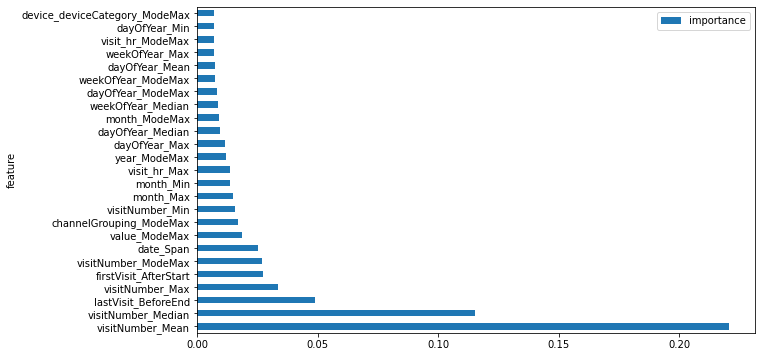

In [ ]:
cls_imp = pd.DataFrame({"feature":trainX_cls.columns,
                        "importance":[val[0] for val in cls_model.feature_importances_.reshape(-1,1)]}).sort_values(by="importance",ascending=False)[:25]

cls_imp.plot(kind="barh", x="feature", y="importance", figsize=(10,6))

In [ ]:
%%time
reg_model.fit(trainX_reg,trainY_reg)

CPU times: user 155 ms, sys: 13 ms, total: 168 ms
Wall time: 163 ms


XGBRegressor(learning_rate=0.05, max_depth=1, n_estimators=50, n_jobs=-1,
             objective='reg:squarederror', predictor='gpu_predictor',
             tree_method='gpu_hist')

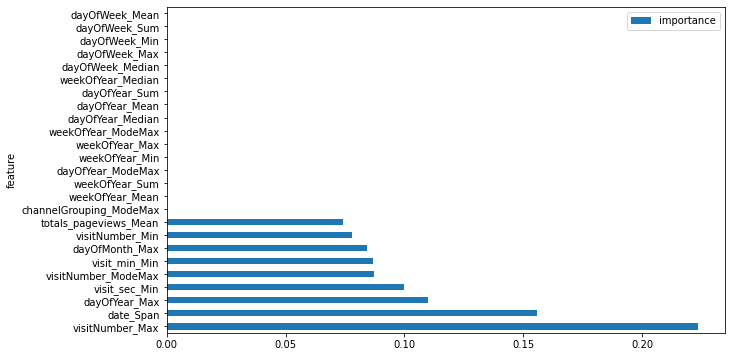

In [ ]:
reg_imp = pd.DataFrame({"feature":trainX_reg.columns,
                        "importance":[val[0] for val in reg_model.feature_importances_.reshape(-1,1)]}).sort_values(by="importance",ascending=False)[:25]

reg_imp.plot(kind="barh", x="feature", y="importance", figsize=(10,6))

In [ ]:
# saving the model:-
filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.2/gbdt_cls_model.sav'
pickle.dump(cls_model, open(filename, 'wb'))

filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.2/gbdt_reg_model.sav'
pickle.dump(reg_model, open(filename, 'wb'))

### <font color='#088da5'>Prediction using the Best Hyper-parameter Tuned Models</font>

In [ ]:
cls_pred = cls_model.predict_proba(testX)[:,1]
print(cls_pred)
reg_pred = reg_model.predict(testX)
print(reg_pred)

[0.00135306 0.00028343 0.00035198 ... 0.00112599 0.00033407 0.00146895]
[0.30577573 0.30577573 0.30577573 ... 0.30577573 0.30577573 0.30577573]


In [ ]:
testY_pred = cls_pred*reg_pred
print(testY_pred.shape)
print(testY_pred)

(296530,)
[4.13733535e-04 8.66671253e-05 1.07627078e-04 ... 3.44301836e-04
 1.02149505e-04 4.49170242e-04]


In [ ]:
subm = pd.DataFrame(data={"fullVisitorId":test["fullVisitorId"],"PredictedLogRevenue":testY_pred})

In [ ]:
print("Negative predicted revenue check:",set(subm['PredictedLogRevenue']<0))

Negative predicted revenue check: {False}


In [ ]:
subm.to_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.2/submit_GBDT1.csv",index=False)
subm.head()

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.000414
1,0000039738481224681,0.000087
2,0000073585230191399,0.000108
3,0000087588448856385,0.000074
4,0000149787903119437,0.000082


## 4.3. <font color='#8fce00'>GBDT-2: XGBClassifier + XGBRegressor</font>

GridSearchCV Hyper-parameter tuning:-
* cls - max_depth, n_estimators, learning_rate
* reg - max_depth, n_estimators, learning_rate

tree_method = "gpu_hist"<br>

### <font color='#088da5'>Defining: Classification & Regression Models for GridSearchCV</font>

In [ ]:
cls_gbdt = XGBClassifier(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor")
params_cls = {'max_depth': [1,2,3,4,5,10,15,20], 'n_estimators':[50,100,150,200,500,1000], 'learning_rate':[0.0001,0.001,0.05,0.1,0.5,1]}

reg_gbdt = XGBRegressor(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor", objective="reg:squarederror")
params_reg = {'max_depth': [1,2,3,4,5,10,15,20], 'n_estimators':[50,100,150,200,500,1000], 'learning_rate':[0.0001,0.001,0.05,0.1,0.5,1]}

In [ ]:
cls_grid = get_CrossValidators(validator_type="G",model_type="cls",estimator_val=cls_gbdt,params=params_cls)
reg_grid = get_CrossValidators(validator_type="G",model_type="reg",estimator_val=reg_gbdt,params=params_reg)

### <font color='#088da5'>Fitting the GridSearchCV</font>

In [ ]:
%%time
cls_grid.fit(trainX_cls,trainY_cls)

CPU times: user 6h 30min 40s, sys: 3min 49s, total: 6h 34min 29s
Wall time: 6h 32min 7s


GridSearchCV(cv=[(array([     0,      1,      2, ..., 236262, 236263, 236264]),
                  array([236265, 236266, 236267, ..., 472524, 472525, 472526])),
                 (array([     0,      1,      2, ..., 472524, 472525, 472526]),
                  array([472527, 472528, 472529, ..., 708786, 708787, 708788])),
                 (array([     0,      1,      2, ..., 708786, 708787, 708788]),
                  array([708789, 708790, 708791, ..., 945048, 945049, 945050])),
                 (array([     0,      1,      2, ..., 945048, 945049, 945050]),
                  a...
                 (array([      0,       1,       2, ..., 1181310, 1181311, 1181312]),
                  array([1181313, 1181314, 1181315, ..., 1417572, 1417573, 1417574]))],
             estimator=XGBClassifier(n_jobs=-1, predictor='gpu_predictor',
                                     tree_method='gpu_hist'),
             param_grid={'learning_rate': [0.0001, 0.001, 0.05, 0.1, 0.5, 1],
                         

In [ ]:
%%time
reg_grid.fit(trainX_reg,trainY_reg)

CPU times: user 48min 31s, sys: 39.6 s, total: 49min 11s
Wall time: 48min 49s


GridSearchCV(cv=[(array([   0,    1,    2, ..., 1454, 1455, 1456]),
                  array([1457, 1458, 1459, ..., 2906, 2907, 2908])),
                 (array([   0,    1,    2, ..., 2906, 2907, 2908]),
                  array([2909, 2910, 2911, ..., 4358, 4359, 4360])),
                 (array([   0,    1,    2, ..., 4358, 4359, 4360]),
                  array([4361, 4362, 4363, ..., 5810, 5811, 5812])),
                 (array([   0,    1,    2, ..., 5810, 5811, 5812]),
                  array([5813, 5814, 5815, ..., 7262, 7263, 7264])),
                 (array([   0,    1,    2, ......
                  array([7265, 7266, 7267, ..., 8714, 8715, 8716]))],
             estimator=XGBRegressor(n_jobs=-1, objective='reg:squarederror',
                                    predictor='gpu_predictor',
                                    tree_method='gpu_hist'),
             param_grid={'learning_rate': [0.0001, 0.001, 0.05, 0.1, 0.5, 1],
                         'max_depth': [1, 2, 3, 4, 5,

### <font color='#088da5'>Best Parameters obtained via GridSearchCV</font>

In [ ]:
cls_best,reg_best = get_BestScoreParams(cls_grid,reg_grid)

For classifier:-
Best params--> {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200}
Best score--> -0.030070573586093156

For regressor:-
Best params--> {'learning_rate': 0.001, 'max_depth': 1, 'n_estimators': 1000}
Best score--> -2.4336515931738125


### <font color='#088da5'>Training the Classification & Regression models using the Best Parameters obtained</font>

In [ ]:
cls_model = XGBClassifier(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor",
                          n_estimators=cls_best['n_estimators'], max_depth=cls_best['max_depth'], learning_rate=cls_best['learning_rate'])

reg_model = XGBRegressor(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor", objective="reg:squarederror",
                         n_estimators=reg_best['n_estimators'], max_depth=reg_best['max_depth'], learning_rate=reg_best['learning_rate'])

In [ ]:
%%time
cls_model.fit(trainX_cls,trainY_cls)

CPU times: user 10.9 s, sys: 102 ms, total: 11 s
Wall time: 10.9 s


XGBClassifier(learning_rate=0.05, max_depth=4, n_estimators=200, n_jobs=-1,
              predictor='gpu_predictor', tree_method='gpu_hist')

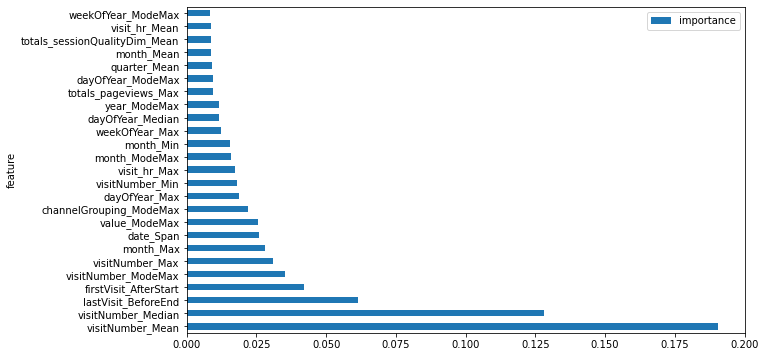

In [ ]:
cls_imp = pd.DataFrame({"feature":trainX_cls.columns,
                        "importance":[val[0] for val in cls_model.feature_importances_.reshape(-1,1)]}).sort_values(by="importance",ascending=False)[:25]

cls_imp.plot(kind="barh", x="feature", y="importance", figsize=(10,6))

In [ ]:
%%time
reg_model.fit(trainX_reg,trainY_reg)

CPU times: user 1.66 s, sys: 26 ms, total: 1.69 s
Wall time: 1.68 s


XGBRegressor(learning_rate=0.001, max_depth=1, n_estimators=1000, n_jobs=-1,
             objective='reg:squarederror', predictor='gpu_predictor',
             tree_method='gpu_hist')

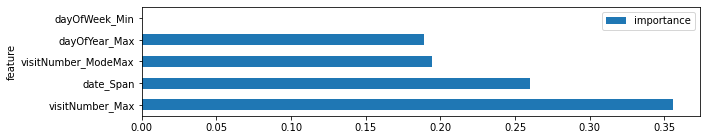

In [ ]:
reg_imp = pd.DataFrame({"feature":trainX_reg.columns,
                        "importance":[val[0] for val in reg_model.feature_importances_.reshape(-1,1)]}).sort_values(by="importance",ascending=False)[:5]

reg_imp.plot(kind="barh", x="feature", y="importance", figsize=(10,2))

In [ ]:
# saving the model:-
filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.3/gbdt_cls_model.sav'
pickle.dump(cls_model, open(filename, 'wb'))

filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.3/gbdt_reg_model.sav'
pickle.dump(reg_model, open(filename, 'wb'))

### <font color='#088da5'>Prediction using the Best Hyper-parameter Tuned Models</font>

In [ ]:
cls_pred = cls_model.predict_proba(testX)[:,1]
print(cls_pred)
reg_pred = reg_model.predict(testX)
print(reg_pred)

[0.00166741 0.00043846 0.00049008 ... 0.00129906 0.00049706 0.00176579]
[0.37639183 0.37639183 0.37639183 ... 0.37639183 0.37639183 0.37639183]


In [ ]:
testY_pred = cls_pred*reg_pred
print(testY_pred.shape)
print(testY_pred)

(296530,)
[0.0006276  0.00016503 0.00018446 ... 0.00048896 0.00018709 0.00066463]


In [ ]:
subm = pd.DataFrame(data={"fullVisitorId":test["fullVisitorId"],"PredictedLogRevenue":testY_pred})

In [ ]:
print("Negative predicted revenue check:",set(subm['PredictedLogRevenue']<0))

Negative predicted revenue check: {False}


In [ ]:
subm.to_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.3/submit_GBDT2.csv",index=False)
subm.head()

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.000628
1,0000039738481224681,0.000165
2,0000073585230191399,0.000184
3,0000087588448856385,0.000153
4,0000149787903119437,0.000160


## 4.4. <font color='#8fce00'>GBDT-3: XGBClassifier + XGBRegressor</font>

RandomizedSearchCV Hyper-parameter tuning:-
* cls - max_depth, n_estimators, learning_rate, subsample
* reg - max_depth, n_estimators, learning_rate, subsample

tree_method = "gpu_hist"<br>
n_iter = 20

### <font color='#088da5'>Defining: Classification & Regression Models for RandomizedSearchCV</font>

In [ ]:
cls_gbdt = XGBClassifier(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor")
params_cls = {'max_depth': [1,2,3,4,5,10,15,20],
              'n_estimators':[50,100,150,200,250,300,350,400,450,500,1000],
              'learning_rate':[0.0001,0.001,0.01,0.05,0.1,0.5,1,10],
              'subsample':[0.2,0.4,0.5,0.6,0.8]}

reg_gbdt = XGBRegressor(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor", objective="reg:squarederror")
params_reg = {'max_depth': [1,2,3,4,5,10,15,20],
              'n_estimators':[50,100,150,200,250,300,350,400,450,500,1000],
              'learning_rate':[0.0001,0.001,0.01,0.05,0.1,0.5,1,10],
              'subsample':[0.2,0.4,0.5,0.6,0.8]}

In [ ]:
cls_rndm = get_CrossValidators(validator_type="R",model_type="cls",estimator_val=cls_gbdt,params=params_cls,n_it=20)
reg_rndm = get_CrossValidators(validator_type="R",model_type="reg",estimator_val=reg_gbdt,params=params_reg,n_it=20)

### <font color='#088da5'>Fitting the RandomizedSearchCV</font>

In [ ]:
%%time
cls_rndm.fit(trainX_cls,trainY_cls)

CPU times: user 27min 16s, sys: 17.3 s, total: 27min 33s
Wall time: 27min 23s


RandomizedSearchCV(cv=[(array([     0,      1,      2, ..., 236262, 236263, 236264]),
                        array([236265, 236266, 236267, ..., 472524, 472525, 472526])),
                       (array([     0,      1,      2, ..., 472524, 472525, 472526]),
                        array([472527, 472528, 472529, ..., 708786, 708787, 708788])),
                       (array([     0,      1,      2, ..., 708786, 708787, 708788]),
                        array([708789, 708790, 708791, ..., 945048, 945049, 945050])),
                       (array([     0,      1,      2, ..., 945048, 945049, 9450...
                        array([1181313, 1181314, 1181315, ..., 1417572, 1417573, 1417574]))],
                   estimator=XGBClassifier(n_jobs=-1, predictor='gpu_predictor',
                                           tree_method='gpu_hist'),
                   n_iter=20,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                             

In [ ]:
%%time
reg_rndm.fit(trainX_reg,trainY_reg)

CPU times: user 3min 19s, sys: 2.8 s, total: 3min 21s
Wall time: 3min 20s


RandomizedSearchCV(cv=[(array([   0,    1,    2, ..., 1454, 1455, 1456]),
                        array([1457, 1458, 1459, ..., 2906, 2907, 2908])),
                       (array([   0,    1,    2, ..., 2906, 2907, 2908]),
                        array([2909, 2910, 2911, ..., 4358, 4359, 4360])),
                       (array([   0,    1,    2, ..., 4358, 4359, 4360]),
                        array([4361, 4362, 4363, ..., 5810, 5811, 5812])),
                       (array([   0,    1,    2, ..., 5810, 5811, 5812]),
                        array([5813, 5814, 5815, ..., 7262, 7263, 7264])),
                       (array([   0,    1...
                                          objective='reg:squarederror',
                                          predictor='gpu_predictor',
                                          tree_method='gpu_hist'),
                   n_iter=20,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                          

### <font color='#088da5'>Best Parameters obtained via RandomizedSearchCV</font>

In [ ]:
cls_best,reg_best = get_BestScoreParams(cls_rndm,reg_rndm)

For classifier:-
Best params--> {'subsample': 0.5, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
Best score--> -0.030206472782087233

For regressor:-
Best params--> {'subsample': 0.4, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.01}
Best score--> -2.4344689007950273


### <font color='#088da5'>Training the Classification & Regression models using the Best Parameters obtained</font>

In [ ]:
cls_model = XGBClassifier(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor",
                          n_estimators=cls_best['n_estimators'], max_depth=cls_best['max_depth'], learning_rate=cls_best['learning_rate'],
                          subsample=cls_best['subsample'])

reg_model = XGBRegressor(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor", objective="reg:squarederror",
                         n_estimators=reg_best['n_estimators'], max_depth=reg_best['max_depth'], learning_rate=reg_best['learning_rate'],
                         subsample=reg_best['subsample'])

In [ ]:
%%time
cls_model.fit(trainX_cls,trainY_cls)

CPU times: user 6.43 s, sys: 90.1 ms, total: 6.52 s
Wall time: 6.49 s


XGBClassifier(n_jobs=-1, predictor='gpu_predictor', subsample=0.5,
              tree_method='gpu_hist')

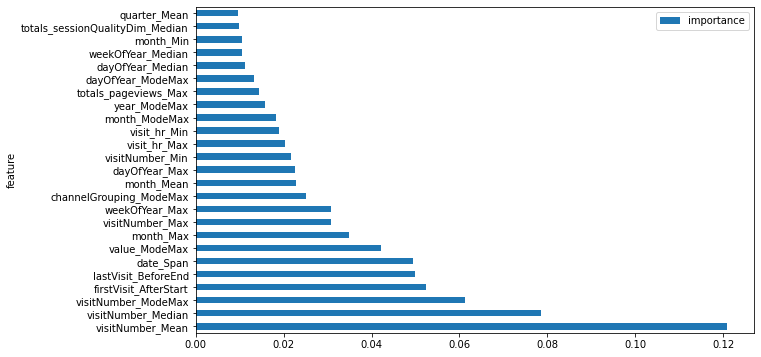

In [ ]:
cls_imp = pd.DataFrame({"feature":trainX_cls.columns,
                        "importance":[val[0] for val in cls_model.feature_importances_.reshape(-1,1)]}).sort_values(by="importance",ascending=False)[:25]

cls_imp.plot(kind="barh", x="feature", y="importance", figsize=(10,6))

In [ ]:
%%time
reg_model.fit(trainX_reg,trainY_reg)

CPU times: user 254 ms, sys: 19 ms, total: 273 ms
Wall time: 268 ms


XGBRegressor(learning_rate=0.01, max_depth=2, n_jobs=-1,
             objective='reg:squarederror', predictor='gpu_predictor',
             subsample=0.4, tree_method='gpu_hist')

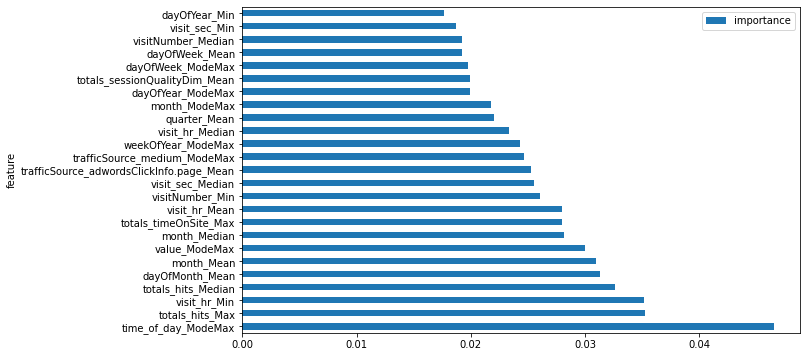

In [ ]:
reg_imp = pd.DataFrame({"feature":trainX_reg.columns,
                        "importance":[val[0] for val in reg_model.feature_importances_.reshape(-1,1)]}).sort_values(by="importance",ascending=False)[:25]

reg_imp.plot(kind="barh", x="feature", y="importance", figsize=(10,6))

In [ ]:
# saving the model:-
filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.4/gbdt_cls_model.sav'
pickle.dump(cls_model, open(filename, 'wb'))

filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.4/gbdt_reg_model.sav'
pickle.dump(reg_model, open(filename, 'wb'))

### <font color='#088da5'>Prediction using the Best Hyper-parameter Tuned Models</font>

In [ ]:
cls_pred = cls_model.predict_proba(testX)[:,1]
print(cls_pred)
reg_pred = reg_model.predict(testX)
print(reg_pred)

[0.0021791  0.00108839 0.00088906 ... 0.00174065 0.00108806 0.00229064]
[0.37212116 0.36477786 0.354882   ... 0.4178721  0.36688328 0.36074767]


In [ ]:
testY_pred = cls_pred*reg_pred
print(testY_pred.shape)
print(testY_pred)

(296530,)
[0.00081089 0.00039702 0.00031551 ... 0.00072737 0.00039919 0.00082634]


In [ ]:
subm = pd.DataFrame(data={"fullVisitorId":test["fullVisitorId"],"PredictedLogRevenue":testY_pred})

In [ ]:
print("Negative predicted revenue check:",set(subm['PredictedLogRevenue']<0))

Negative predicted revenue check: {False}


In [ ]:
subm.to_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.4/submit_GBDT3.csv",index=False)
subm.head()

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.000811
1,0000039738481224681,0.000397
2,0000073585230191399,0.000316
3,0000087588448856385,0.000265
4,0000149787903119437,0.000315


## 4.5. <font color='#8fce00'>GBDT-4: XGBClassifier + XGBRegressor</font>

RandomizedSearchCV Hyper-parameter tuning:-
* cls - max_depth, n_estimators, learning_rate, subsample, colsample_bytree, colsample_bylevel, colsample_bynode
* reg - max_depth, n_estimators, learning_rate, subsample, colsample_bytree, colsample_bylevel, colsample_bynode

tree_method = "gpu_hist"<br>
n_iter = 10 (default)

### <font color='#088da5'>Defining: Classification & Regression Models for RandomizedSearchCV</font>

In [ ]:
cls_gbdt = XGBClassifier(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor")
params_cls = {'max_depth': [1,2,3,4,5,10,15,20],
              'n_estimators':[50,100,150,200,250,300,350,400,450,500,1000],
              'learning_rate':[0.0001,0.001,0.01,0.05,0.1,0.5,1,10],
              'subsample':[0.2,0.4,0.5,0.6,0.8],
              'colsample_bytree':[0.2,0.4,0.5,0.6,0.8],
              'colsample_bylevel':[0.2,0.4,0.5,0.6,0.8],
              'colsample_bynode':[0.2,0.4,0.5,0.6,0.8]}

reg_gbdt = XGBRegressor(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor", objective="reg:squarederror")
params_reg = {'max_depth': [1,2,3,4,5,10,15,20],
              'n_estimators':[50,100,150,200,250,300,350,400,450,500,1000],
              'learning_rate':[0.0001,0.001,0.01,0.05,0.1,0.5,1,10],
              'subsample':[0.2,0.4,0.5,0.6,0.8],
              'colsample_bytree':[0.2,0.4,0.5,0.6,0.8],
              'colsample_bylevel':[0.2,0.4,0.5,0.6,0.8],
              'colsample_bynode':[0.2,0.4,0.5,0.6,0.8]}

In [ ]:
cls_rndm = get_CrossValidators(validator_type="R",model_type="cls",estimator_val=cls_gbdt,params=params_cls)
reg_rndm = get_CrossValidators(validator_type="R",model_type="reg",estimator_val=reg_gbdt,params=params_reg)

### <font color='#088da5'>Fitting the RandomizedSearchCV</font>

In [ ]:
%%time
cls_rndm.fit(trainX_cls,trainY_cls)

CPU times: user 11min 1s, sys: 9.5 s, total: 11min 11s
Wall time: 11min 7s


RandomizedSearchCV(cv=[(array([     0,      1,      2, ..., 236262, 236263, 236264]),
                        array([236265, 236266, 236267, ..., 472524, 472525, 472526])),
                       (array([     0,      1,      2, ..., 472524, 472525, 472526]),
                        array([472527, 472528, 472529, ..., 708786, 708787, 708788])),
                       (array([     0,      1,      2, ..., 708786, 708787, 708788]),
                        array([708789, 708790, 708791, ..., 945048, 945049, 945050])),
                       (array([     0,      1,      2, ..., 945048, 945049, 9450...
                   param_distributions={'colsample_bylevel': [0.2, 0.4, 0.5,
                                                              0.6, 0.8],
                                        'colsample_bynode': [0.2, 0.4, 0.5, 0.6,
                                                             0.8],
                                        'colsample_bytree': [0.2, 0.4, 0.5, 0.6,
                  

In [ ]:
%%time
reg_rndm.fit(trainX_reg,trainY_reg)

CPU times: user 1min 24s, sys: 2.23 s, total: 1min 26s
Wall time: 1min 26s


RandomizedSearchCV(cv=[(array([   0,    1,    2, ..., 1454, 1455, 1456]),
                        array([1457, 1458, 1459, ..., 2906, 2907, 2908])),
                       (array([   0,    1,    2, ..., 2906, 2907, 2908]),
                        array([2909, 2910, 2911, ..., 4358, 4359, 4360])),
                       (array([   0,    1,    2, ..., 4358, 4359, 4360]),
                        array([4361, 4362, 4363, ..., 5810, 5811, 5812])),
                       (array([   0,    1,    2, ..., 5810, 5811, 5812]),
                        array([5813, 5814, 5815, ..., 7262, 7263, 7264])),
                       (array([   0,    1...
                   param_distributions={'colsample_bylevel': [0.2, 0.4, 0.5,
                                                              0.6, 0.8],
                                        'colsample_bynode': [0.2, 0.4, 0.5, 0.6,
                                                             0.8],
                                        'colsample_bytree': [

### <font color='#088da5'>Best Parameters obtained via RandomizedSearchCV</font>

In [ ]:
cls_best,reg_best = get_BestScoreParams(cls_rndm,reg_rndm)

For classifier:-
Best params--> {'subsample': 0.2, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.6, 'colsample_bynode': 0.2, 'colsample_bylevel': 0.2}
Best score--> -0.032105040316868935

For regressor:-
Best params--> {'subsample': 0.6, 'n_estimators': 1000, 'max_depth': 2, 'learning_rate': 0.0001, 'colsample_bytree': 0.4, 'colsample_bynode': 0.2, 'colsample_bylevel': 0.4}
Best score--> -2.4380172543833494


### <font color='#088da5'>Training the Classification & Regression models using the Best Parameters obtained</font>

In [ ]:
cls_model = XGBClassifier(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor",
                          n_estimators=cls_best['n_estimators'], max_depth=cls_best['max_depth'], learning_rate=cls_best['learning_rate'],
                          subsample=cls_best['subsample'], colsample_bytree=cls_best['colsample_bytree'],
                          colsample_bylevel=cls_best['colsample_bylevel'], colsample_bynode=cls_best['colsample_bynode'])

reg_model = XGBRegressor(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor", objective="reg:squarederror",
                         n_estimators=reg_best['n_estimators'], max_depth=reg_best['max_depth'], learning_rate=reg_best['learning_rate'],
                         subsample=reg_best['subsample'], colsample_bytree=reg_best['colsample_bytree'],
                         colsample_bylevel=reg_best['colsample_bylevel'], colsample_bynode=reg_best['colsample_bynode'])

In [ ]:
%%time
cls_model.fit(trainX_cls,trainY_cls)

CPU times: user 10.2 s, sys: 116 ms, total: 10.3 s
Wall time: 10.3 s


XGBClassifier(colsample_bylevel=0.2, colsample_bynode=0.2, colsample_bytree=0.6,
              learning_rate=0.05, max_depth=5, n_estimators=150, n_jobs=-1,
              predictor='gpu_predictor', subsample=0.2, tree_method='gpu_hist')

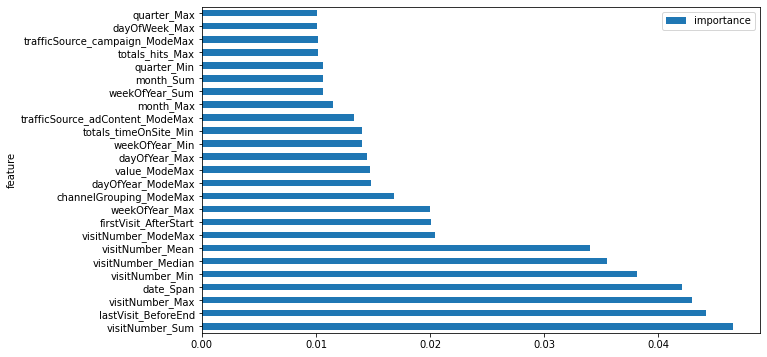

In [ ]:
cls_imp = pd.DataFrame({"feature":trainX_cls.columns,
                        "importance":[val[0] for val in cls_model.feature_importances_.reshape(-1,1)]}).sort_values(by="importance",ascending=False)[:25]

cls_imp.plot(kind="barh", x="feature", y="importance", figsize=(10,6))

In [ ]:
%%time
reg_model.fit(trainX_reg,trainY_reg)

CPU times: user 1.87 s, sys: 32 ms, total: 1.9 s
Wall time: 1.89 s


XGBRegressor(colsample_bylevel=0.4, colsample_bynode=0.2, colsample_bytree=0.4,
             learning_rate=0.0001, max_depth=2, n_estimators=1000, n_jobs=-1,
             objective='reg:squarederror', predictor='gpu_predictor',
             subsample=0.6, tree_method='gpu_hist')

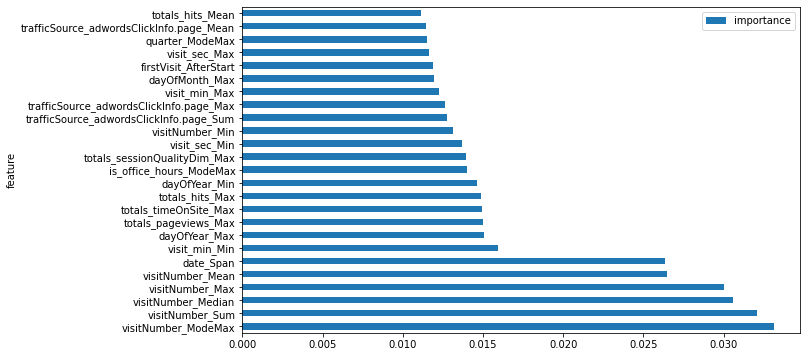

In [ ]:
reg_imp = pd.DataFrame({"feature":trainX_reg.columns,
                        "importance":[val[0] for val in reg_model.feature_importances_.reshape(-1,1)]}).sort_values(by="importance",ascending=False)[:25]

reg_imp.plot(kind="barh", x="feature", y="importance", figsize=(10,6))

In [ ]:
# saving the model:-
filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.5/gbdt_cls_model.sav'
pickle.dump(cls_model, open(filename, 'wb'))

filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.5/gbdt_reg_model.sav'
pickle.dump(reg_model, open(filename, 'wb'))

### <font color='#088da5'>Prediction using the Best Hyper-parameter Tuned Models</font>

In [ ]:
cls_pred = cls_model.predict_proba(testX)[:,1]
print(cls_pred)
reg_pred = reg_model.predict(testX)
print(reg_pred)

[0.00244595 0.00645003 0.00720232 ... 0.00256007 0.00705967 0.00290076]
[0.48283988 0.4824992  0.48100534 ... 0.48481613 0.48149654 0.48245752]


In [ ]:
testY_pred = cls_pred*reg_pred
print(testY_pred.shape)
print(testY_pred)

(296530,)
[0.001181   0.00311213 0.00346436 ... 0.00124116 0.00339921 0.00139949]


In [ ]:
subm = pd.DataFrame(data={"fullVisitorId":test["fullVisitorId"],"PredictedLogRevenue":testY_pred})

In [ ]:
print("Negative predicted revenue check:",set(subm['PredictedLogRevenue']<0))

Negative predicted revenue check: {False}


In [ ]:
subm.to_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.5/submit_GBDT4.csv",index=False)
subm.head()

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.001181
1,0000039738481224681,0.003112
2,0000073585230191399,0.003464
3,0000087588448856385,0.002127
4,0000149787903119437,0.003165


## 4.6. <font color='#8fce00'>RF: RandomForestClassifier + RandomForestRegressor</font>

RandomizedSearchCV Hyper-parameter tuning:-
* cls - n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf, max_features
* reg - n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features

n_iter = 10 (default)

### <font color='#088da5'>Defining: Classification & Regression Models for RandomizedSearchCV</font>

In [ ]:
cls_rf = RandomForestClassifier(n_jobs=-1)
params_cls = {'n_estimators':[50,100,150,200,300,500], 'criterion':["gini", "entropy"], 'max_depth':[1,2,3,4,5,10,15,20],
              'min_samples_split':[2,3,4,5,10], 'min_samples_leaf':[1,2,3,4,5], 'max_features':['sqrt','log2']}

reg_rf = RandomForestRegressor(n_jobs=-1)
params_reg = {'n_estimators':[50,100,150,200,300,500], 'max_depth':[1,2,3,4,5,10,15,20],
              'min_samples_split':[2,3,4,5,10], 'min_samples_leaf':[1,2,3,4,5], 'max_features':['sqrt','log2']}

In [ ]:
cls_rndm = get_CrossValidators(validator_type="R",model_type="cls",estimator_val=cls_rf,params=params_cls)
reg_rndm = get_CrossValidators(validator_type="R",model_type="reg",estimator_val=reg_rf,params=params_reg)

### <font color='#088da5'>Fitting the RandomizedSearchCV</font>

In [ ]:
%%time
cls_rndm.fit(trainX_cls,trainY_cls)

CPU times: user 45min 12s, sys: 27.6 s, total: 45min 39s
Wall time: 1h 41min 45s


RandomizedSearchCV(cv=[(array([     0,      1,      2, ..., 236262, 236263, 236264]),
                        array([236265, 236266, 236267, ..., 472524, 472525, 472526])),
                       (array([     0,      1,      2, ..., 472524, 472525, 472526]),
                        array([472527, 472528, 472529, ..., 708786, 708787, 708788])),
                       (array([     0,      1,      2, ..., 708786, 708787, 708788]),
                        array([708789, 708790, 708791, ..., 945048, 945049, 945050])),
                       (array([     0,      1,      2, ..., 945048, 945049, 9450...
                        array([1181313, 1181314, 1181315, ..., 1417572, 1417573, 1417574]))],
                   estimator=RandomForestClassifier(n_jobs=-1),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 10, 15,
                                                      20],
                             

In [ ]:
%%time
reg_rndm.fit(trainX_reg,trainY_reg)

CPU times: user 27 s, sys: 3.76 s, total: 30.7 s
Wall time: 44.6 s


RandomizedSearchCV(cv=[(array([   0,    1,    2, ..., 1454, 1455, 1456]),
                        array([1457, 1458, 1459, ..., 2906, 2907, 2908])),
                       (array([   0,    1,    2, ..., 2906, 2907, 2908]),
                        array([2909, 2910, 2911, ..., 4358, 4359, 4360])),
                       (array([   0,    1,    2, ..., 4358, 4359, 4360]),
                        array([4361, 4362, 4363, ..., 5810, 5811, 5812])),
                       (array([   0,    1,    2, ..., 5810, 5811, 5812]),
                        array([5813, 5814, 5815, ..., 7262, 7263, 7264])),
                       (array([   0,    1...63, 7264]),
                        array([7265, 7266, 7267, ..., 8714, 8715, 8716]))],
                   estimator=RandomForestRegressor(n_jobs=-1),
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 10, 15,
                                                      20],
                                        'max_features': ['sqrt', 'log2'],

### <font color='#088da5'>Best Parameters obtained via RandomizedSearchCV</font>

In [ ]:
cls_best,reg_best = get_BestScoreParams(cls_rndm,reg_rndm)

For classifier:-
Best params--> {'n_estimators': 500, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 2, 'criterion': 'entropy'}
Best score--> -0.033780284933446564

For regressor:-
Best params--> {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 3}
Best score--> -2.4350708932771132


### <font color='#088da5'>Training the Classification & Regression models using the Best Parameters obtained</font>

In [ ]:
cls_model = RandomForestClassifier(n_jobs=-1,n_estimators=cls_best['n_estimators'], criterion=cls_best['criterion'], max_depth=cls_best['max_depth'],
                                   min_samples_split=cls_best['min_samples_split'], min_samples_leaf=cls_best['min_samples_leaf'],
                                   max_features=cls_best['max_features'])

reg_model = RandomForestRegressor(n_jobs=-1,n_estimators=reg_best['n_estimators'], max_depth=reg_best['max_depth'],
                                  min_samples_split=reg_best['min_samples_split'], min_samples_leaf=reg_best['min_samples_leaf'],
                                  max_features=reg_best['max_features'])

In [ ]:
%%time
cls_model.fit(trainX_cls,trainY_cls)

CPU times: user 21min 51s, sys: 2.63 s, total: 21min 53s
Wall time: 5min 33s


RandomForestClassifier(criterion='entropy', max_depth=2, max_features='sqrt',
                       min_samples_leaf=5, min_samples_split=4,
                       n_estimators=500, n_jobs=-1)

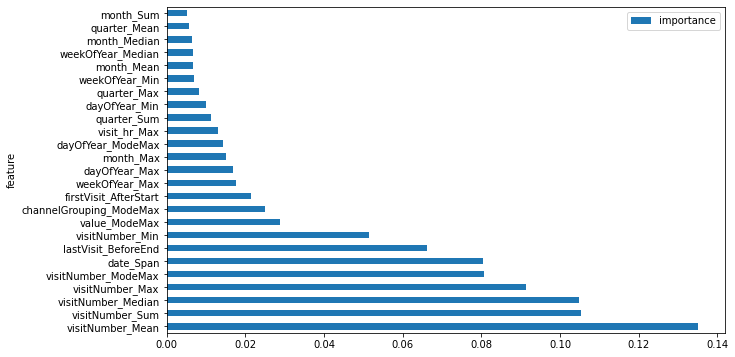

In [ ]:
cls_imp = pd.DataFrame({"feature":trainX_cls.columns,
                        "importance":[val[0] for val in cls_model.feature_importances_.reshape(-1,1)]}).sort_values(by="importance",ascending=False)[:25]

cls_imp.plot(kind="barh", x="feature", y="importance", figsize=(10,6))

In [ ]:
%%time
reg_model.fit(trainX_reg,trainY_reg)

CPU times: user 2.56 s, sys: 122 ms, total: 2.68 s
Wall time: 929 ms


RandomForestRegressor(max_depth=3, max_features='sqrt', min_samples_split=10,
                      n_estimators=300, n_jobs=-1)

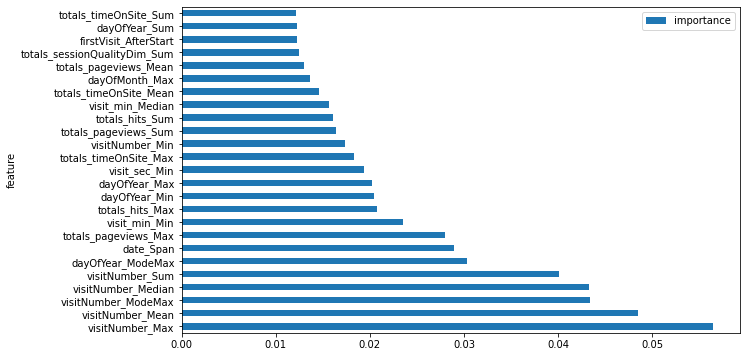

In [ ]:
reg_imp = pd.DataFrame({"feature":trainX_reg.columns,
                        "importance":[val[0] for val in reg_model.feature_importances_.reshape(-1,1)]}).sort_values(by="importance",ascending=False)[:25]

reg_imp.plot(kind="barh", x="feature", y="importance", figsize=(10,6))

In [ ]:
# saving the model:-
filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.6/rf_cls_model.sav'
pickle.dump(cls_model, open(filename, 'wb'))

filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.6/rf_reg_model.sav'
pickle.dump(reg_model, open(filename, 'wb'))

### <font color='#088da5'>Prediction using the Best Hyper-parameter Tuned Models</font>

In [ ]:
cls_pred = cls_model.predict_proba(testX)[:,1]
print(cls_pred)
reg_pred = reg_model.predict(testX)
print(reg_pred)

[0.0043401  0.00514031 0.00493954 ... 0.0042262  0.0050692  0.00437555]
[0.2699375  0.27083026 0.29745349 ... 0.37474642 0.26791933 0.27225163]


In [ ]:
testY_pred = cls_pred*reg_pred
print(testY_pred.shape)
print(testY_pred)

(296530,)
[0.00117156 0.00139215 0.00146928 ... 0.00158375 0.00135814 0.00119125]


In [ ]:
subm = pd.DataFrame(data={"fullVisitorId":test["fullVisitorId"],"PredictedLogRevenue":testY_pred})

In [ ]:
print("Negative predicted revenue check:",set(subm['PredictedLogRevenue']<0))

Negative predicted revenue check: {False}


In [ ]:
subm.to_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.6/submit_RF.csv",index=False)
subm.head()

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.001172
1,0000039738481224681,0.001392
2,0000073585230191399,0.001469
3,0000087588448856385,0.001235
4,0000149787903119437,0.001188


## 4.7. <font color='#8fce00'>Ensemble-1</font>

* RandomizedSearchCv
* Classification Ensembles:-
  * RandomForestClassifier + XGBClassifier
* Regression Ensembles:-
  * RandomForestRegressor + XGBRegressor


### <font color='#088da5'>Defining: Classification & Regression Models for RandomizedSearchCV</font>

In [ ]:
# RF.
cls_rf = RandomForestClassifier(n_jobs=-1)
params_cls_rf = {'n_estimators':[50,100,150,200,300,500],'max_depth':[1,2,3,4,5,10,15,20]}

reg_rf = RandomForestRegressor(n_jobs=-1)
params_reg_rf = {'n_estimators':[50,100,150,200,300,500], 'max_depth':[1,2,3,4,5,10,15,20]}

# XGB.
cls_gbdt = XGBClassifier(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor")
params_cls_xgb = {'max_depth': [1,2,3,4,5,10,15,20], 'n_estimators':[50,100,150,200,300,500], 'learning_rate':[0.0001,0.001,0.05,0.1,0.5,1]}

reg_gbdt = XGBRegressor(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor", objective="reg:squarederror")
params_reg_xgb = {'max_depth': [1,2,3,4,5,10,15,20], 'n_estimators':[50,100,150,200,300,500], 'learning_rate':[0.0001,0.001,0.05,0.1,0.5,1]}

In [ ]:
# RF.
cls_rndm_rf = get_CrossValidators(validator_type="R",model_type="cls",estimator_val=cls_rf,params=params_cls_rf)
reg_rndm_rf = get_CrossValidators(validator_type="R",model_type="reg",estimator_val=reg_rf,params=params_reg_rf)

# XGB.
cls_rndm_xgb = get_CrossValidators(validator_type="R",model_type="cls",estimator_val=cls_gbdt,params=params_cls_xgb)
reg_rndm_xgb = get_CrossValidators(validator_type="R",model_type="reg",estimator_val=reg_gbdt,params=params_reg_xgb)

### <font color='#088da5'>Fitting the RandomizedSearchCV</font>

In [ ]:
# RF.

In [ ]:
%%time
cls_rndm_rf.fit(trainX_cls,trainY_cls)

CPU times: user 40min 13s, sys: 31.5 s, total: 40min 44s
Wall time: 1h 55min 26s


RandomizedSearchCV(cv=[(array([     0,      1,      2, ..., 236262, 236263, 236264]),
                        array([236265, 236266, 236267, ..., 472524, 472525, 472526])),
                       (array([     0,      1,      2, ..., 472524, 472525, 472526]),
                        array([472527, 472528, 472529, ..., 708786, 708787, 708788])),
                       (array([     0,      1,      2, ..., 708786, 708787, 708788]),
                        array([708789, 708790, 708791, ..., 945048, 945049, 945050])),
                       (array([     0,      1,      2, ..., 945048, 945049, 9450...
                        array([ 945051,  945052,  945053, ..., 1181310, 1181311, 1181312])),
                       (array([      0,       1,       2, ..., 1181310, 1181311, 1181312]),
                        array([1181313, 1181314, 1181315, ..., 1417572, 1417573, 1417574]))],
                   estimator=RandomForestClassifier(n_jobs=-1),
                   param_distributions={'max_depth': [

In [ ]:
%%time
reg_rndm_rf.fit(trainX_reg,trainY_reg)

CPU times: user 30.7 s, sys: 3.14 s, total: 33.9 s
Wall time: 2min 37s


RandomizedSearchCV(cv=[(array([   0,    1,    2, ..., 1454, 1455, 1456]),
                        array([1457, 1458, 1459, ..., 2906, 2907, 2908])),
                       (array([   0,    1,    2, ..., 2906, 2907, 2908]),
                        array([2909, 2910, 2911, ..., 4358, 4359, 4360])),
                       (array([   0,    1,    2, ..., 4358, 4359, 4360]),
                        array([4361, 4362, 4363, ..., 5810, 5811, 5812])),
                       (array([   0,    1,    2, ..., 5810, 5811, 5812]),
                        array([5813, 5814, 5815, ..., 7262, 7263, 7264])),
                       (array([   0,    1,    2, ..., 7262, 7263, 7264]),
                        array([7265, 7266, 7267, ..., 8714, 8715, 8716]))],
                   estimator=RandomForestRegressor(n_jobs=-1),
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 10, 15,
                                                      20],
                                        'n_estimators':

In [ ]:
# XGB.

In [ ]:
%%time
cls_rndm_xgb.fit(trainX_cls,trainY_cls)

CPU times: user 8min 44s, sys: 7.9 s, total: 8min 52s
Wall time: 8min 49s


RandomizedSearchCV(cv=[(array([     0,      1,      2, ..., 236262, 236263, 236264]),
                        array([236265, 236266, 236267, ..., 472524, 472525, 472526])),
                       (array([     0,      1,      2, ..., 472524, 472525, 472526]),
                        array([472527, 472528, 472529, ..., 708786, 708787, 708788])),
                       (array([     0,      1,      2, ..., 708786, 708787, 708788]),
                        array([708789, 708790, 708791, ..., 945048, 945049, 945050])),
                       (array([     0,      1,      2, ..., 945048, 945049, 9450...
                       (array([      0,       1,       2, ..., 1181310, 1181311, 1181312]),
                        array([1181313, 1181314, 1181315, ..., 1417572, 1417573, 1417574]))],
                   estimator=XGBClassifier(n_jobs=-1, predictor='gpu_predictor',
                                           tree_method='gpu_hist'),
                   param_distributions={'learning_rate': [0.00

In [ ]:
%%time
reg_rndm_xgb.fit(trainX_reg,trainY_reg)

CPU times: user 2min 9s, sys: 1.46 s, total: 2min 10s
Wall time: 2min 9s


RandomizedSearchCV(cv=[(array([   0,    1,    2, ..., 1454, 1455, 1456]),
                        array([1457, 1458, 1459, ..., 2906, 2907, 2908])),
                       (array([   0,    1,    2, ..., 2906, 2907, 2908]),
                        array([2909, 2910, 2911, ..., 4358, 4359, 4360])),
                       (array([   0,    1,    2, ..., 4358, 4359, 4360]),
                        array([4361, 4362, 4363, ..., 5810, 5811, 5812])),
                       (array([   0,    1,    2, ..., 5810, 5811, 5812]),
                        array([5813, 5814, 5815, ..., 7262, 7263, 7264])),
                       (array([   0,    1...
                        array([7265, 7266, 7267, ..., 8714, 8715, 8716]))],
                   estimator=XGBRegressor(n_jobs=-1,
                                          objective='reg:squarederror',
                                          predictor='gpu_predictor',
                                          tree_method='gpu_hist'),
                   par

### <font color='#088da5'>Best Parameters obtained via RandomizedSearchCV</font>

In [ ]:
# RF.
cls_best_rf,reg_best_rf = get_BestScoreParams(cls_rndm_rf,reg_rndm_rf)

For classifier:-
Best params--> {'n_estimators': 300, 'max_depth': 3}
Best score--> -0.034176421500792135

For regressor:-
Best params--> {'n_estimators': 300, 'max_depth': 1}
Best score--> -2.4338475414861307


In [ ]:
# XGB.
cls_best_xgb,reg_best_xgb = get_BestScoreParams(cls_rndm_xgb,reg_rndm_xgb)

For classifier:-
Best params--> {'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.5}
Best score--> -0.030842207188649877

For regressor:-
Best params--> {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.001}
Best score--> -2.443751672306379


### <font color='#088da5'>Training the Classification & Regression models using the Best Parameters obtained</font>

In [ ]:
# RF.
cls_model_rf = RandomForestClassifier(n_jobs=-1,
                                      n_estimators=cls_best_rf['n_estimators'], max_depth=cls_best_rf['max_depth'])

reg_model_rf = RandomForestRegressor(n_jobs=-1,
                                     n_estimators=reg_best_rf['n_estimators'], max_depth=reg_best_rf['max_depth'])

# XGB.
cls_model_xgb = XGBClassifier(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor",
                              n_estimators=cls_best_xgb['n_estimators'], max_depth=cls_best_xgb['max_depth'], learning_rate=cls_best_xgb['learning_rate'])

reg_model_xgb = XGBRegressor(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor", objective="reg:squarederror",
                             n_estimators=reg_best_xgb['n_estimators'], max_depth=reg_best_xgb['max_depth'], learning_rate=reg_best_xgb['learning_rate'])

In [ ]:
# RF.

In [ ]:
%%time
cls_model_rf.fit(trainX_cls,trainY_cls)

CPU times: user 18min 56s, sys: 1.85 s, total: 18min 58s
Wall time: 4min 48s


RandomForestClassifier(max_depth=3, n_estimators=300, n_jobs=-1)

In [ ]:
%%time
reg_model_rf.fit(trainX_reg,trainY_reg)

CPU times: user 7.67 s, sys: 54 ms, total: 7.72 s
Wall time: 2.13 s


RandomForestRegressor(max_depth=1, n_estimators=300, n_jobs=-1)

In [ ]:
# XGB.

In [ ]:
%%time
cls_model_xgb.fit(trainX_cls,trainY_cls)

CPU times: user 4.64 s, sys: 202 ms, total: 4.84 s
Wall time: 4.81 s


XGBClassifier(learning_rate=0.5, max_depth=4, n_estimators=50, n_jobs=-1,
              predictor='gpu_predictor', tree_method='gpu_hist')

In [ ]:
%%time
reg_model_xgb.fit(trainX_reg,trainY_reg)

CPU times: user 3.42 s, sys: 31 ms, total: 3.45 s
Wall time: 3.42 s


XGBRegressor(learning_rate=0.001, max_depth=20, n_jobs=-1,
             objective='reg:squarederror', predictor='gpu_predictor',
             tree_method='gpu_hist')

In [ ]:
# saving the model:-
# RF.
filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.7/rf_cls_model.sav'
pickle.dump(cls_model_rf, open(filename, 'wb'))

filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.7/rf_reg_model.sav'
pickle.dump(reg_model_rf, open(filename, 'wb'))

# XGB.
filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.7/gbdt_cls_model.sav'
pickle.dump(cls_model_xgb, open(filename, 'wb'))

filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.7/gbdt_reg_model.sav'
pickle.dump(reg_model_xgb, open(filename, 'wb'))

### <font color='#088da5'>Prediction using the Best Hyper-parameter Tuned Models</font>

In [ ]:
# RF.
cls_pred_rf = cls_model_rf.predict_proba(testX)[:,1]
print(cls_pred_rf)
reg_pred_rf = reg_model_rf.predict(testX)
print(reg_pred_rf)

# XGB.
cls_pred_xgb = cls_model_xgb.predict_proba(testX)[:,1]
print(cls_pred_xgb)
reg_pred_xgb = reg_model_xgb.predict(testX)
print(reg_pred_xgb)

[0.00423027 0.00483731 0.00479985 ... 0.00363146 0.00505562 0.00433683]
[0.31171723 0.31171723 0.31171723 ... 0.31519395 0.31171723 0.31171723]
[0.00203068 0.00051882 0.00036385 ... 0.00155009 0.00040245 0.00208111]
[0.45247105 0.45247105 1.6545976  ... 0.45334047 0.45244062 0.45244062]


In [ ]:
testY_pred_rf = cls_pred_rf*reg_pred_rf
print(testY_pred_rf.shape)
print(testY_pred_rf)

testY_pred_xgb = cls_pred_xgb*reg_pred_xgb
print(testY_pred_xgb.shape)
print(testY_pred_xgb)

(296530,)
[0.00131865 0.00150787 0.00149619 ... 0.00114461 0.00157592 0.00135186]
(296530,)
[0.00091882 0.00023475 0.00060203 ... 0.00070272 0.00018209 0.00094158]


In [ ]:
testY_pred = np.add(testY_pred_rf,testY_pred_xgb) / 2
print(testY_pred.shape)
testY_pred

(296530,)


array([0.00111873, 0.00087131, 0.00104911, ..., 0.00092367, 0.00087901,
       0.00114672])

In [ ]:
subm = pd.DataFrame(data={"fullVisitorId":test["fullVisitorId"],"PredictedLogRevenue":testY_pred})

In [ ]:
print("Negative predicted revenue check:",set(subm['PredictedLogRevenue']<0))

Negative predicted revenue check: {False}


In [ ]:
subm.to_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.7/submit_Ensemble1.csv",index=False)
subm.head()

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.001119
1,0000039738481224681,0.000871
2,0000073585230191399,0.001049
3,0000087588448856385,0.000714
4,0000149787903119437,0.000720


## 4.8. <font color='#8fce00'>Ensemble-2</font>

* RandomizedSearchCV Hyper-parameter tuning
* Classification Ensembles:-
  * LogisticRegression, GaussianNB, RandomForestClassifier, XGBClassifier
* Regression Ensembles:-
  * Lasso, KNeighborsRegressor, RandomForestRegressor, XGBRegressor

### <font color='#088da5'>Defining: Classification & Regression Models for RandomizedSearchCV</font>


#### <font color='orange'>COMBINATION-1 BASE LEARNERS: LogisticRegression + Lasso</font>


In [ ]:
# LogisticRegression
ensemble2Cls_define_LogReg = LogisticRegression(n_jobs=-1)
ensemble2Cls_params_LogReg = {"penalty":["l1","l2"],
                              "C":[10**i for i in range(-5,6)]}

# Lasso
ensemble2Reg_define_Lasso = Lasso()
ensemble2Reg_params_Lasso = {"alpha":[10**i for i in range(-5,6)]}                             

In [ ]:
ensemble2Cls_COMB1 = get_CrossValidators(validator_type="R",model_type="cls",estimator_val=ensemble2Cls_define_LogReg,params=ensemble2Cls_params_LogReg)
ensemble2Reg_COMB1 = get_CrossValidators(validator_type="R",model_type="reg",estimator_val=ensemble2Reg_define_Lasso,params=ensemble2Reg_params_Lasso)

#### <font color='orange'>COMBINATION-2 BASE LEARNERS: GaussianNB + KNeighborsRegressor</font>


In [ ]:
# GaussianNB
ensemble2Cls_define_NB = GaussianNB()
ensemble2Cls_params_NB = {"var_smoothing":[10**i for i in range(-10,3)]}

# KNeighborsRegressor
ensemble2Reg_define_KNN = KNeighborsRegressor(n_jobs=-1)
ensemble2Reg_params_KNN = {"n_neighbors":[1,2,3,4,5]}                           

In [ ]:
ensemble2Cls_COMB2 = get_CrossValidators(validator_type="R",model_type="cls",estimator_val=ensemble2Cls_define_NB,params=ensemble2Cls_params_NB)
ensemble2Reg_COMB2 = get_CrossValidators(validator_type="R",model_type="reg",estimator_val=ensemble2Reg_define_KNN,params=ensemble2Reg_params_KNN)

#### <font color='orange'>COMBINATION-3 BASE LEARNERS: RandomForestClassifier + RandomForestRegressor</font>


In [ ]:
# RandomForestClassifier
ensemble2Cls_define_RF = RandomForestClassifier(n_jobs=-1)
ensemble2Cls_params_RF = {"n_estimators":[50,100,200,300,400,500,600,700,800,900,1000],
                          "max_depth":[1,2,3,4,5,10,15,20],
                          "min_samples_split":[2,4,6,8],
                          "min_samples_leaf":[2,4,6,8]}

# RandomForestRegressor
ensemble2Reg_define_RF = RandomForestRegressor(n_jobs=-1)
ensemble2Reg_params_RF = {"n_estimators":[50,100,200,300,400,500,600,700,800,900,1000],
                          "max_depth":[1,2,3,4,5,10,15,20],
                          "min_samples_split":[2,4,6,8],
                          "min_samples_leaf":[2,4,6,8]}                          

In [ ]:
ensemble2Cls_COMB3 = get_CrossValidators(validator_type="R",model_type="cls",estimator_val=ensemble2Cls_define_RF,params=ensemble2Cls_params_RF)
ensemble2Reg_COMB3 = get_CrossValidators(validator_type="R",model_type="reg",estimator_val=ensemble2Reg_define_RF,params=ensemble2Reg_params_RF)

#### <font color='orange'>COMBINATION-4 BASE LEARNERS: XGBClassifier + XGBRegressor</font>


In [ ]:
# XGBClassifier
ensemble2Cls_define_XGB = XGBClassifier(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor")
ensemble2Cls_params_XGB = {'max_depth': [1,2,3,4,5,10,15,20],
                           'n_estimators':[50,100,150,200,250,300,350,400,450,500,1000],
                           'learning_rate':[0.0001,0.001,0.01,0.05,0.1,0.5,1,10],
                           'subsample':[0.2,0.4,0.5,0.6,0.8]}

# XGBRegressor
ensemble2Reg_define_XGB = XGBRegressor(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor", objective="reg:squarederror")
ensemble2Reg_params_XGB = {'max_depth': [1,2,3,4,5,10,15,20],
                           'n_estimators':[50,100,150,200,250,300,350,400,450,500,1000],
                           'learning_rate':[0.0001,0.001,0.01,0.05,0.1,0.5,1,10],
                           'subsample':[0.2,0.4,0.5,0.6,0.8]}                          

In [ ]:
ensemble2Cls_COMB4 = get_CrossValidators(validator_type="R",model_type="cls",estimator_val=ensemble2Cls_define_XGB,params=ensemble2Cls_params_XGB)
ensemble2Reg_COMB4 = get_CrossValidators(validator_type="R",model_type="reg",estimator_val=ensemble2Reg_define_XGB,params=ensemble2Reg_params_XGB)

### <font color='#088da5'>Fitting the RandomizedSearchCV</font>

#### <font color='orange'>COMBINATION-1 BASE LEARNERS: LogisticRegression + Lasso</font>


In [ ]:
%%time
ensemble2Cls_COMB1.fit(trainX_cls,trainY_cls)

CPU times: user 1min 19s, sys: 35 s, total: 1min 54s
Wall time: 1h 47min 7s


RandomizedSearchCV(cv=[(array([     0,      1,      2, ..., 236262, 236263, 236264]),
                        array([236265, 236266, 236267, ..., 472524, 472525, 472526])),
                       (array([     0,      1,      2, ..., 472524, 472525, 472526]),
                        array([472527, 472528, 472529, ..., 708786, 708787, 708788])),
                       (array([     0,      1,      2, ..., 708786, 708787, 708788]),
                        array([708789, 708790, 708791, ..., 945048, 945049, 945050])),
                       (array([     0,      1,      2, ..., 945048, 945049, 9450...
                        array([ 945051,  945052,  945053, ..., 1181310, 1181311, 1181312])),
                       (array([      0,       1,       2, ..., 1181310, 1181311, 1181312]),
                        array([1181313, 1181314, 1181315, ..., 1417572, 1417573, 1417574]))],
                   estimator=LogisticRegression(n_jobs=-1),
                   param_distributions={'C': [1e-05, 0.000

In [ ]:
%%time
ensemble2Reg_COMB1.fit(trainX_reg,trainY_reg)

CPU times: user 10.8 s, sys: 13.9 s, total: 24.7 s
Wall time: 8.27 s


RandomizedSearchCV(cv=[(array([   0,    1,    2, ..., 1454, 1455, 1456]),
                        array([1457, 1458, 1459, ..., 2906, 2907, 2908])),
                       (array([   0,    1,    2, ..., 2906, 2907, 2908]),
                        array([2909, 2910, 2911, ..., 4358, 4359, 4360])),
                       (array([   0,    1,    2, ..., 4358, 4359, 4360]),
                        array([4361, 4362, 4363, ..., 5810, 5811, 5812])),
                       (array([   0,    1,    2, ..., 5810, 5811, 5812]),
                        array([5813, 5814, 5815, ..., 7262, 7263, 7264])),
                       (array([   0,    1,    2, ..., 7262, 7263, 7264]),
                        array([7265, 7266, 7267, ..., 8714, 8715, 8716]))],
                   estimator=Lasso(),
                   param_distributions={'alpha': [1e-05, 0.0001, 0.001, 0.01,
                                                  0.1, 1, 10, 100, 1000, 10000,
                                                  100000]}

#### <font color='orange'>COMBINATION-2 BASE LEARNERS: GaussianNB + KNeighborsRegressor</font>


In [ ]:
%%time
ensemble2Cls_COMB2.fit(trainX_cls,trainY_cls)

CPU times: user 2min 32s, sys: 2.12 s, total: 2min 34s
Wall time: 2min 33s


RandomizedSearchCV(cv=[(array([     0,      1,      2, ..., 236262, 236263, 236264]),
                        array([236265, 236266, 236267, ..., 472524, 472525, 472526])),
                       (array([     0,      1,      2, ..., 472524, 472525, 472526]),
                        array([472527, 472528, 472529, ..., 708786, 708787, 708788])),
                       (array([     0,      1,      2, ..., 708786, 708787, 708788]),
                        array([708789, 708790, 708791, ..., 945048, 945049, 945050])),
                       (array([     0,      1,      2, ..., 945048, 945049, 945050]),
                        array([ 945051,  945052,  945053, ..., 1181310, 1181311, 1181312])),
                       (array([      0,       1,       2, ..., 1181310, 1181311, 1181312]),
                        array([1181313, 1181314, 1181315, ..., 1417572, 1417573, 1417574]))],
                   estimator=GaussianNB(),
                   param_distributions={'var_smoothing': [1e-10, 1e-09, 1

In [ ]:
%%time
ensemble2Reg_COMB2.fit(trainX_reg,trainY_reg)

CPU times: user 29.2 s, sys: 18.8 s, total: 48.1 s
Wall time: 18.6 s


RandomizedSearchCV(cv=[(array([   0,    1,    2, ..., 1454, 1455, 1456]),
                        array([1457, 1458, 1459, ..., 2906, 2907, 2908])),
                       (array([   0,    1,    2, ..., 2906, 2907, 2908]),
                        array([2909, 2910, 2911, ..., 4358, 4359, 4360])),
                       (array([   0,    1,    2, ..., 4358, 4359, 4360]),
                        array([4361, 4362, 4363, ..., 5810, 5811, 5812])),
                       (array([   0,    1,    2, ..., 5810, 5811, 5812]),
                        array([5813, 5814, 5815, ..., 7262, 7263, 7264])),
                       (array([   0,    1,    2, ..., 7262, 7263, 7264]),
                        array([7265, 7266, 7267, ..., 8714, 8715, 8716]))],
                   estimator=KNeighborsRegressor(n_jobs=-1),
                   param_distributions={'n_neighbors': [1, 2, 3, 4, 5]},
                   return_train_score=True,
                   scoring='neg_root_mean_squared_error')

#### <font color='orange'>COMBINATION-3 BASE LEARNERS: RandomForestClassifier + RandomForestRegressor</font>


In [ ]:
%%time
ensemble2Cls_COMB3.fit(trainX_cls,trainY_cls)

CPU times: user 1h 48min 7s, sys: 42.2 s, total: 1h 48min 49s
Wall time: 4h 40min 28s


RandomizedSearchCV(cv=[(array([     0,      1,      2, ..., 236262, 236263, 236264]),
                        array([236265, 236266, 236267, ..., 472524, 472525, 472526])),
                       (array([     0,      1,      2, ..., 472524, 472525, 472526]),
                        array([472527, 472528, 472529, ..., 708786, 708787, 708788])),
                       (array([     0,      1,      2, ..., 708786, 708787, 708788]),
                        array([708789, 708790, 708791, ..., 945048, 945049, 945050])),
                       (array([     0,      1,      2, ..., 945048, 945049, 9450...
                       (array([      0,       1,       2, ..., 1181310, 1181311, 1181312]),
                        array([1181313, 1181314, 1181315, ..., 1417572, 1417573, 1417574]))],
                   estimator=RandomForestClassifier(n_jobs=-1),
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 10, 15,
                                                      20],
           

In [ ]:
%%time
ensemble2Reg_COMB3.fit(trainX_reg,trainY_reg)

CPU times: user 52.5 s, sys: 3.79 s, total: 56.3 s
Wall time: 5min


RandomizedSearchCV(cv=[(array([   0,    1,    2, ..., 1454, 1455, 1456]),
                        array([1457, 1458, 1459, ..., 2906, 2907, 2908])),
                       (array([   0,    1,    2, ..., 2906, 2907, 2908]),
                        array([2909, 2910, 2911, ..., 4358, 4359, 4360])),
                       (array([   0,    1,    2, ..., 4358, 4359, 4360]),
                        array([4361, 4362, 4363, ..., 5810, 5811, 5812])),
                       (array([   0,    1,    2, ..., 5810, 5811, 5812]),
                        array([5813, 5814, 5815, ..., 7262, 7263, 7264])),
                       (array([   0,    1,    2, ..., 7262, 7263, 7264]),
                        array([7265, 7266, 7267, ..., 8714, 8715, 8716]))],
                   estimator=RandomForestRegressor(n_jobs=-1),
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 10, 15,
                                                      20],
                                        'min_samples_le

#### <font color='orange'>COMBINATION-4 BASE LEARNERS: XGBClassifier + XGBRegressor</font>


In [ ]:
%%time
ensemble2Cls_COMB4.fit(trainX_cls,trainY_cls)

CPU times: user 6min 54s, sys: 6.93 s, total: 7min
Wall time: 6min 59s


RandomizedSearchCV(cv=[(array([     0,      1,      2, ..., 236262, 236263, 236264]),
                        array([236265, 236266, 236267, ..., 472524, 472525, 472526])),
                       (array([     0,      1,      2, ..., 472524, 472525, 472526]),
                        array([472527, 472528, 472529, ..., 708786, 708787, 708788])),
                       (array([     0,      1,      2, ..., 708786, 708787, 708788]),
                        array([708789, 708790, 708791, ..., 945048, 945049, 945050])),
                       (array([     0,      1,      2, ..., 945048, 945049, 9450...
                        array([1181313, 1181314, 1181315, ..., 1417572, 1417573, 1417574]))],
                   estimator=XGBClassifier(n_jobs=-1, predictor='gpu_predictor',
                                           tree_method='gpu_hist'),
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.05, 0.1, 0.5, 1

In [ ]:
%%time
ensemble2Reg_COMB4.fit(trainX_reg,trainY_reg)

CPU times: user 2min 4s, sys: 1.38 s, total: 2min 5s
Wall time: 2min 4s


RandomizedSearchCV(cv=[(array([   0,    1,    2, ..., 1454, 1455, 1456]),
                        array([1457, 1458, 1459, ..., 2906, 2907, 2908])),
                       (array([   0,    1,    2, ..., 2906, 2907, 2908]),
                        array([2909, 2910, 2911, ..., 4358, 4359, 4360])),
                       (array([   0,    1,    2, ..., 4358, 4359, 4360]),
                        array([4361, 4362, 4363, ..., 5810, 5811, 5812])),
                       (array([   0,    1,    2, ..., 5810, 5811, 5812]),
                        array([5813, 5814, 5815, ..., 7262, 7263, 7264])),
                       (array([   0,    1...
                   estimator=XGBRegressor(n_jobs=-1,
                                          objective='reg:squarederror',
                                          predictor='gpu_predictor',
                                          tree_method='gpu_hist'),
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                   

### <font color='#088da5'>Best Parameters obtained via RandomizedSearchCV</font>

#### <font color='orange'>COMBINATION-1 BASE LEARNERS: LogisticRegression + Lasso</font>


In [ ]:
cls_best_COMB1,reg_best_COMB1 = get_BestScoreParams(ensemble2Cls_COMB1,ensemble2Reg_COMB1)

For classifier:-
Best params--> {'penalty': 'l2', 'C': 10}
Best score--> -0.03267662359602145

For regressor:-
Best params--> {'alpha': 10}
Best score--> -2.429918264540567


#### <font color='orange'>COMBINATION-2 BASE LEARNERS: GaussianNB + KNeighborsRegressor</font>


In [ ]:
cls_best_COMB2,reg_best_COMB2 = get_BestScoreParams(ensemble2Cls_COMB2,ensemble2Reg_COMB2)

For classifier:-
Best params--> {'var_smoothing': 10}
Best score--> -0.03866093342901905

For regressor:-
Best params--> {'n_neighbors': 5}
Best score--> -2.6314070903222193


#### <font color='orange'>COMBINATION-3 BASE LEARNERS: RandomForestClassifier + RandomForestRegressor</font>


In [ ]:
cls_best_COMB3,reg_best_COMB3 = get_BestScoreParams(ensemble2Cls_COMB3,ensemble2Reg_COMB3)

For classifier:-
Best params--> {'n_estimators': 1000, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_depth': 3}
Best score--> -0.034168064072431274

For regressor:-
Best params--> {'n_estimators': 600, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_depth': 1}
Best score--> -2.429106819544415


#### <font color='orange'>COMBINATION-4 BASE LEARNERS: XGBClassifier + XGBRegressor</font>


In [ ]:
cls_best_COMB4,reg_best_COMB4 = get_BestScoreParams(ensemble2Cls_COMB4,ensemble2Reg_COMB4)

For classifier:-
Best params--> {'subsample': 0.6, 'n_estimators': 1000, 'max_depth': 1, 'learning_rate': 0.1}
Best score--> -0.030478525586128385

For regressor:-
Best params--> {'subsample': 0.2, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.01}
Best score--> -2.4439450018883817


### <font color='#088da5'>Training the Classification & Regression models using the Best Parameters obtained</font>

In [ ]:
def train_tuned_models(combination_number,cls_best_params,reg_best_params):
  if combination_number==1:
    cls_model = LogisticRegression(n_jobs=-1,
                                   penalty=cls_best_params["penalty"],
                                   C=cls_best_params["C"])
    reg_model = Lasso(alpha=reg_best_params["alpha"])

  if combination_number==2:
    cls_model = GaussianNB(var_smoothing=cls_best_params['var_smoothing'])
    reg_model = KNeighborsRegressor(n_jobs=-1,
                                    n_neighbors=reg_best_params["n_neighbors"])

  if combination_number==3:
    cls_model = RandomForestClassifier(n_jobs=-1,
                                       n_estimators=cls_best_params["n_estimators"],
                                       max_depth=cls_best_params["max_depth"],
                                       min_samples_split=cls_best_params["min_samples_split"],
                                       min_samples_leaf=cls_best_params["min_samples_leaf"])
    reg_model = RandomForestRegressor(n_jobs=-1,
                                      n_estimators=reg_best_params["n_estimators"],
                                      max_depth=reg_best_params["max_depth"],
                                      min_samples_split=reg_best_params["min_samples_split"],
                                      min_samples_leaf=reg_best_params["min_samples_leaf"])

  if combination_number==4:
    cls_model = XGBClassifier(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor",
                              n_estimators=cls_best_params["n_estimators"],
                              max_depth=cls_best_params["max_depth"],
                              learning_rate=cls_best_params["learning_rate"])
    reg_model = XGBRegressor(tree_method='gpu_hist', n_jobs=-1, predictor="gpu_predictor", objective="reg:squarederror",
                             n_estimators=reg_best_params["n_estimators"],
                             max_depth=reg_best_params["max_depth"],
                             learning_rate=reg_best_params["learning_rate"])

  return cls_model,reg_model

#### <font color='orange'>COMBINATION-1 BASE LEARNERS: LogisticRegression + Lasso</font>


In [ ]:
ensemble2ClsTunedModel_COMB1,ensemble2RegTunedModel_COMB1 = train_tuned_models(1,cls_best_COMB1,reg_best_COMB1)

In [ ]:
%%time
ensemble2ClsTunedModel_COMB1.fit(trainX_cls,trainY_cls)

CPU times: user 2.89 s, sys: 1.01 s, total: 3.9 s
Wall time: 7min 14s


LogisticRegression(C=10, n_jobs=-1)

In [ ]:
%%time
ensemble2RegTunedModel_COMB1.fit(trainX_reg,trainY_reg)

CPU times: user 118 ms, sys: 207 ms, total: 325 ms
Wall time: 105 ms


Lasso(alpha=10)

In [ ]:
# saving the model:-
filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.8/ensemble2ClsTunedModel_COMB1.sav'
pickle.dump(ensemble2ClsTunedModel_COMB1, open(filename, 'wb'))

filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.8/ensemble2RegTunedModel_COMB1.sav'
pickle.dump(ensemble2RegTunedModel_COMB1, open(filename, 'wb'))

#### <font color='orange'>COMBINATION-2 BASE LEARNERS: GaussianNB + KNeighborsRegressor</font>


In [ ]:
ensemble2ClsTunedModel_COMB2,ensemble2RegTunedModel_COMB2 = train_tuned_models(2,cls_best_COMB2,reg_best_COMB2)

In [ ]:
%%time
ensemble2ClsTunedModel_COMB2.fit(trainX_cls,trainY_cls)

CPU times: user 2.38 s, sys: 12.1 ms, total: 2.39 s
Wall time: 2.38 s


GaussianNB(var_smoothing=10)

In [ ]:
%%time
ensemble2RegTunedModel_COMB2.fit(trainX_reg,trainY_reg)

CPU times: user 6.11 ms, sys: 19 µs, total: 6.13 ms
Wall time: 5.51 ms


KNeighborsRegressor(n_jobs=-1)

In [ ]:
# saving the model:-
filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.8/ensemble2ClsTunedModel_COMB2.sav'
pickle.dump(ensemble2ClsTunedModel_COMB2, open(filename, 'wb'))

filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.8/ensemble2RegTunedModel_COMB2.sav'
pickle.dump(ensemble2RegTunedModel_COMB2, open(filename, 'wb'))

#### <font color='orange'>COMBINATION-3 BASE LEARNERS: RandomForestClassifier + RandomForestRegressor</font>


In [ ]:
ensemble2ClsTunedModel_COMB3,ensemble2RegTunedModel_COMB3 = train_tuned_models(3,cls_best_COMB3,reg_best_COMB3)

In [ ]:
%%time
ensemble2ClsTunedModel_COMB3.fit(trainX_cls,trainY_cls)

CPU times: user 47min 21s, sys: 2.97 s, total: 47min 24s
Wall time: 11min 58s


RandomForestClassifier(max_depth=3, min_samples_leaf=4, min_samples_split=8,
                       n_estimators=1000, n_jobs=-1)

In [ ]:
%%time
ensemble2RegTunedModel_COMB3.fit(trainX_reg,trainY_reg)

CPU times: user 15.2 s, sys: 69.1 ms, total: 15.2 s
Wall time: 4.09 s


RandomForestRegressor(max_depth=1, min_samples_leaf=8, min_samples_split=6,
                      n_estimators=600, n_jobs=-1)

In [ ]:
# saving the model:-
filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.8/ensemble2ClsTunedModel_COMB3.sav'
pickle.dump(ensemble2ClsTunedModel_COMB3, open(filename, 'wb'))

filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.8/ensemble2RegTunedModel_COMB3.sav'
pickle.dump(ensemble2RegTunedModel_COMB3, open(filename, 'wb'))

#### <font color='orange'>COMBINATION-4 BASE LEARNERS: XGBClassifier + XGBRegressor</font>


In [ ]:
ensemble2ClsTunedModel_COMB4,ensemble2RegTunedModel_COMB4 = train_tuned_models(4,cls_best_COMB4,reg_best_COMB4)

In [ ]:
%%time
ensemble2ClsTunedModel_COMB4.fit(trainX_cls,trainY_cls)

CPU times: user 29.3 s, sys: 92.1 ms, total: 29.4 s
Wall time: 29.3 s


XGBClassifier(max_depth=1, n_estimators=1000, n_jobs=-1,
              predictor='gpu_predictor', tree_method='gpu_hist')

In [ ]:
%%time
ensemble2RegTunedModel_COMB4.fit(trainX_reg,trainY_reg)

CPU times: user 348 ms, sys: 21 ms, total: 369 ms
Wall time: 365 ms


XGBRegressor(learning_rate=0.01, n_estimators=150, n_jobs=-1,
             objective='reg:squarederror', predictor='gpu_predictor',
             tree_method='gpu_hist')

In [ ]:
# saving the model:-
filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.8/ensemble2ClsTunedModel_COMB4.sav'
pickle.dump(ensemble2ClsTunedModel_COMB4, open(filename, 'wb'))

filename = '/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.8/ensemble2RegTunedModel_COMB4.sav'
pickle.dump(ensemble2RegTunedModel_COMB4, open(filename, 'wb'))

### <font color='#088da5'>Prediction using the Best Hyper-parameter Tuned Models</font>

In [ ]:
def get_predictions(cls_model,reg_model,test_data):
  cls_pred = cls_model.predict_proba(test_data)[:,1]
  reg_pred = reg_model.predict(test_data)
  multiply_pred = cls_pred*reg_pred
  return multiply_pred

#### <font color='orange'>COMBINATION-1 BASE LEARNERS: LogisticRegression + Lasso</font>


In [ ]:
pred_COMB1 = get_predictions(ensemble2ClsTunedModel_COMB1,ensemble2RegTunedModel_COMB1,testX)
print(pred_COMB1.shape) # sanity

(296530,)


In [ ]:
subm = pd.DataFrame(data={"fullVisitorId":test["fullVisitorId"],"PredictedLogRevenue":pred_COMB1})
subm.to_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.8/submit_Ensemble2_COMB1.csv",index=False)
subm.head()

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.000895
1,0000039738481224681,0.000232
2,0000073585230191399,0.000209
3,0000087588448856385,0.000226
4,0000149787903119437,0.000186


#### <font color='orange'>COMBINATION-2 BASE LEARNERS: GaussianNB + KNeighborsRegressor</font>


In [ ]:
pred_COMB2 = get_predictions(ensemble2ClsTunedModel_COMB2,ensemble2RegTunedModel_COMB2,testX)
print(pred_COMB2.shape) # sanity

(296530,)


In [ ]:
subm = pd.DataFrame(data={"fullVisitorId":test["fullVisitorId"],"PredictedLogRevenue":pred_COMB2})
subm.to_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.8/submit_Ensemble2_COMB2.csv",index=False)
subm.head()

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.0
1,0000039738481224681,0.0
2,0000073585230191399,0.0
3,0000087588448856385,0.0
4,0000149787903119437,0.0


#### <font color='orange'>COMBINATION-3 BASE LEARNERS: RandomForestClassifier + RandomForestRegressor</font>


In [ ]:
pred_COMB3 = get_predictions(ensemble2ClsTunedModel_COMB3,ensemble2RegTunedModel_COMB3,testX)
print(pred_COMB3.shape) # sanity

(296530,)


In [ ]:
subm = pd.DataFrame(data={"fullVisitorId":test["fullVisitorId"],"PredictedLogRevenue":pred_COMB3})
subm.to_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.8/submit_Ensemble2_COMB3.csv",index=False)
subm.head()

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.001285
1,0000039738481224681,0.001500
2,0000073585230191399,0.001487
3,0000087588448856385,0.001323
4,0000149787903119437,0.001330


#### <font color='orange'>COMBINATION-4 BASE LEARNERS: XGBClassifier + XGBRegressor</font>


In [ ]:
pred_COMB4 = get_predictions(ensemble2ClsTunedModel_COMB4,ensemble2RegTunedModel_COMB4,testX)
print(pred_COMB4.shape) # sanity

(296530,)


In [ ]:
subm = pd.DataFrame(data={"fullVisitorId":test["fullVisitorId"],"PredictedLogRevenue":pred_COMB4})
subm.to_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.8/submit_Ensemble2_COMB4.csv",index=False)
subm.head()

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.000523
1,0000039738481224681,0.000368
2,0000073585230191399,0.000379
3,0000087588448856385,0.000201
4,0000149787903119437,0.000295


#### <font color='orange'>Ensembling Predictions from All 4 Combinations</font>


In [ ]:
res1 = np.add(pred_COMB1,pred_COMB2)
res2 = np.add(res1,pred_COMB3)
testY_pred = np.add(res2,pred_COMB4) / 4
print(testY_pred.shape)
testY_pred

(296530,)


array([0.00067606, 0.00052508, 0.00051877, ..., 0.0006627 , 0.00058259,
       0.00083332])

In [ ]:
subm = pd.DataFrame(data={"fullVisitorId":test["fullVisitorId"],"PredictedLogRevenue":testY_pred})

In [ ]:
print("Negative predicted revenue check:",set(subm['PredictedLogRevenue']<0))

Negative predicted revenue check: {False, True}


In [ ]:
subm["PredictedLogRevenue"] = subm["PredictedLogRevenue"].apply(replace_negative_with_zero)

In [ ]:
subm.to_csv("/content/drive/MyDrive/AAIC - Assignments/SNo.23_Self Case Study 1/Output_Files/models_4.8/submit_Ensemble2.csv",index=False)
subm.head()

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.000676
1,0000039738481224681,0.000525
2,0000073585230191399,0.000519
3,0000087588448856385,0.000437
4,0000149787903119437,0.000453


# <font color="#1b5776">5. <u>Summary</u></font>

In [2]:
x = PrettyTable(["S.No.",
                 "Model",
                 "Kaggle Leaderboard Private Score"])
x.add_row(["0",
           "Logistic Regression + Lasso Regression (GridSearchCV)",
           "0.88742"])
x.add_row(["~~","~~","~~"])
x.add_row(["1",
           "GBDT-1: XGBClassifier + XGBRegressor (RandomizedSearchCV)",
           "0.88679"])
x.add_row(["~~","~~","~~"])
x.add_row(["2",
           "GBDT-2: XGBClassifier + XGBRegressor (GridSearchCV)",
           "0.88667"])
x.add_row(["~~","~~","~~"])
x.add_row(["3",
           "GBDT-3: XGBClassifier + XGBRegressor (RandomizedSearchCV)",
           "0.88656"])
x.add_row(["~~","~~","~~"])
x.add_row(["4",
           "GBDT-4: XGBClassifier + XGBRegressor (RandomizedSearchCV)",
           "0.88768"])
x.add_row(["~~","~~","~~"])
x.add_row(["5",
           "RandomForestClassifier + RandomForestRegressor (RandomizedSearchCV)",
           "0.88802"])
x.add_row(["~~","~~","~~"])
x.add_row(["6",
           "Ensemble-1: RandomForest,XGB (RandomizedSearchCV)",
           "0.88717"])
x.add_row(["~~","~~","~~"])
x.add_row(["7",
           "Ensemble-2: LogisticRegression,GaussianNB,Lasso,KNN,RandomForest,XGB (RandomizedSearchCV)",
           "0.88761"])
print(x)

+-------+-------------------------------------------------------------------------------------------+----------------------------------+
| S.No. |                                           Model                                           | Kaggle Leaderboard Private Score |
+-------+-------------------------------------------------------------------------------------------+----------------------------------+
|   0   |                   Logistic Regression + Lasso Regression (GridSearchCV)                   |             0.88742              |
|   ~~  |                                             ~~                                            |                ~~                |
|   1   |                 GBDT-1: XGBClassifier + XGBRegressor (RandomizedSearchCV)                 |             0.88679              |
|   ~~  |                                             ~~                                            |                ~~                |
|   2   |                    GBDT-2: XGBC

In [ ]:
print("Best Model's Serial Number:",np.argsort([0.88742,0.88679,0.88667,0.88656,0.88768,0.88802,0.88717,0.88761])[0])

Best Model's Serial Number: 3


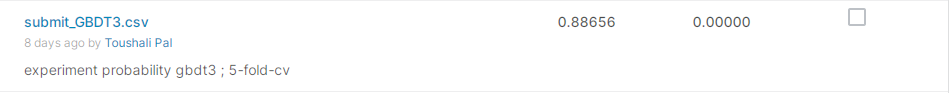

In [ ]:
Image(filename='/content/file-5.1-best-score.PNG')

Conclusion: The GBDT models with RandomizedSearchCV hyper-parameter tuning of max_depth, n_estimators, learning_rate, subsample worked best with Private Kaggle Leaderboard Score: 0.88656.

# <font color="#1b5776">6. <u>Additional References</u></font>

In [ ]:
# https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

# https://scikit-learn.org/stable/modules/model_evaluation.html#:~:text=higher%20return%20values%20are%20better%20than%20lower%20return%20values
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

# https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/
# https://xgboost.readthedocs.io/en/stable/python/python_api.html
# https://xgboost.readthedocs.io/en/stable/parameter.html

# https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html#sklearn.ensemble.StackingRegressor

# https://stackoverflow.com/questions/43275506/scikit-learn-cross-val-predict-only-works-for-partitions
# https://datascience.stackexchange.com/questions/41378/how-to-apply-stacking-cross-validation-for-time-series-data/105116#105116

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# https://xgboost.readthedocs.io/en/stable/python/python_api.html#:~:text=class%20xgboost.XGBClassifier

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# https://xgboost.readthedocs.io/en/stable/python/python_api.html#:~:text=class%20xgboost.XGBRegressor

# https://stackoverflow.com/questions/48366506/calculate-new-column-as-the-mean-of-other-columns-pandas/48366525